# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

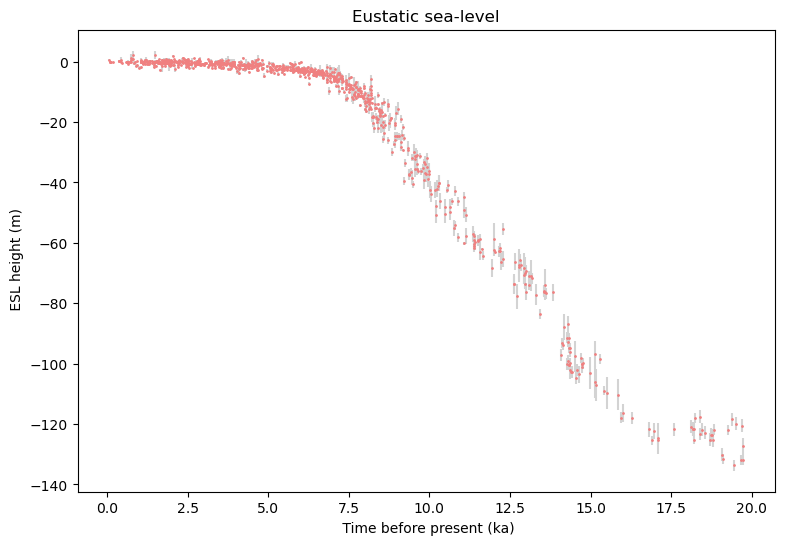

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

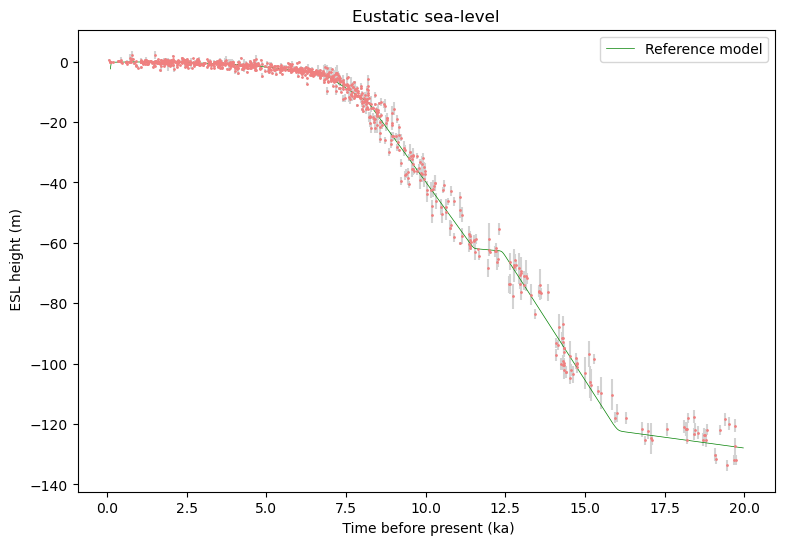

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'sampling', 'matrix solvers', 'optimization'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

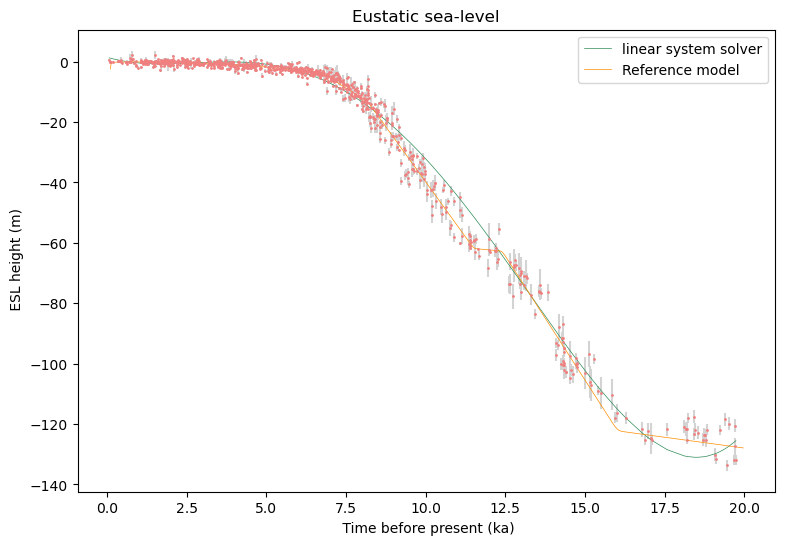

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]

Summary for inversion result
FAILURE
----------------------------
fun: 396.30180936007037
nit: 598
nfev: 1000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 4.02211771, -7.6352002 ,  3.47983694, -0.52237961,  0.02043681],
       [ 4.02227491, -7.63498804,  3.47977907, -0.52238912,  0.02043829],
       [ 4.02218792, -7.63507241,  3.47979137, -0.5223722 ,  0.02043577],
       [ 4.02245903, -7.63488993,  3.47966829, -0.52235893,  0.02043602],
       [ 4.02257488, -7.63525136,  3.47962954, -0.52233062,  0.02043424],
       [ 4.02215782, -7.63502984,  3.47981924, -0.5223883 ,  0.02043736]]), array([396.30180936, 396.30181593, 396.30181983, 396.30182837,
       396.30183836, 396.30184074]))
model: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]


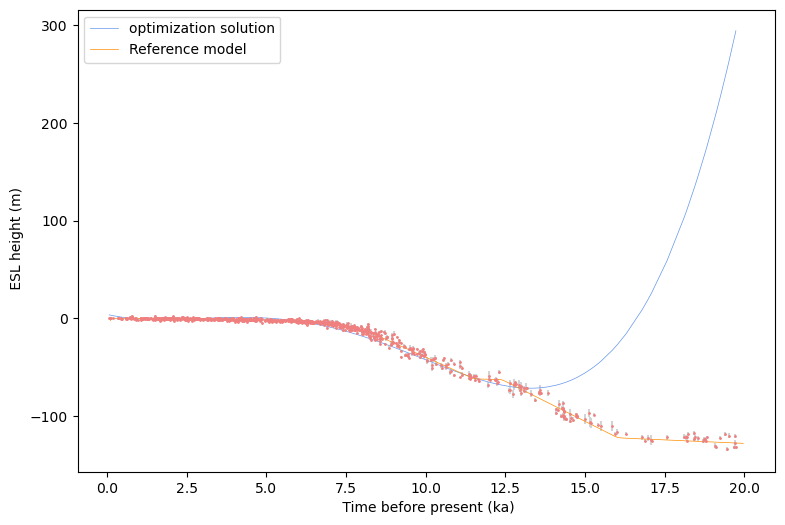

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


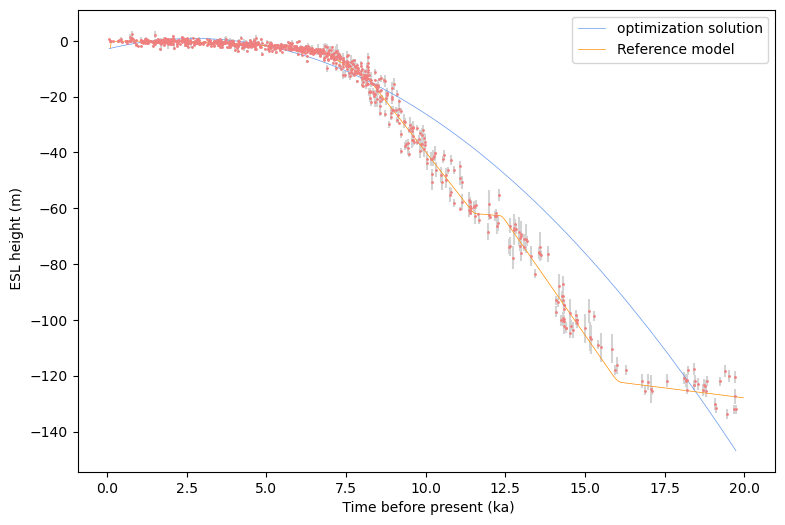

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                         | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                              | 19/10000 [00:00<00:52, 188.64it/s]

  0%|▌                                                                                                                                              | 39/10000 [00:00<00:52, 190.04it/s]

  1%|▊                                                                                                                                              | 59/10000 [00:00<00:52, 190.43it/s]

  1%|█▏                                                                                                                                             | 79/10000 [00:00<00:51, 191.70it/s]

  1%|█▍                                                                                                                                             | 99/10000 [00:00<00:51, 193.27it/s]

  1%|█▋                                                                                                                                            | 119/10000 [00:00<00:50, 194.19it/s]

  1%|█▉                                                                                                                                            | 139/10000 [00:00<00:50, 195.08it/s]

  2%|██▎                                                                                                                                           | 159/10000 [00:00<00:50, 195.46it/s]

  2%|██▌                                                                                                                                           | 179/10000 [00:00<00:50, 195.13it/s]

  2%|██▊                                                                                                                                           | 199/10000 [00:01<00:50, 194.73it/s]

  2%|███                                                                                                                                           | 219/10000 [00:01<00:53, 183.57it/s]

  2%|███▍                                                                                                                                          | 238/10000 [00:01<00:58, 166.47it/s]

  3%|███▌                                                                                                                                          | 255/10000 [00:01<01:02, 155.38it/s]

  3%|███▊                                                                                                                                          | 271/10000 [00:01<01:04, 150.41it/s]

  3%|████                                                                                                                                          | 287/10000 [00:01<01:06, 146.23it/s]

  3%|████▎                                                                                                                                         | 302/10000 [00:01<01:07, 144.12it/s]

  3%|████▌                                                                                                                                         | 317/10000 [00:01<01:08, 141.24it/s]

  3%|████▋                                                                                                                                         | 332/10000 [00:01<01:08, 140.42it/s]

  3%|████▉                                                                                                                                         | 347/10000 [00:02<01:09, 139.36it/s]

  4%|█████▏                                                                                                                                        | 361/10000 [00:02<01:09, 137.71it/s]

  4%|█████▎                                                                                                                                        | 375/10000 [00:02<01:10, 137.41it/s]

  4%|█████▌                                                                                                                                        | 389/10000 [00:02<01:10, 136.07it/s]

  4%|█████▋                                                                                                                                        | 403/10000 [00:02<01:10, 135.49it/s]

  4%|█████▉                                                                                                                                        | 417/10000 [00:02<01:10, 135.65it/s]

  4%|██████                                                                                                                                        | 431/10000 [00:02<01:10, 136.26it/s]

  4%|██████▎                                                                                                                                       | 445/10000 [00:02<01:27, 109.19it/s]

  5%|██████▍                                                                                                                                       | 457/10000 [00:03<01:32, 103.11it/s]

  5%|██████▋                                                                                                                                       | 469/10000 [00:03<01:29, 105.98it/s]

  5%|██████▊                                                                                                                                       | 481/10000 [00:03<01:31, 104.52it/s]

  5%|███████                                                                                                                                       | 495/10000 [00:03<01:23, 113.39it/s]

  5%|███████▏                                                                                                                                      | 507/10000 [00:03<01:22, 114.86it/s]

  5%|███████▍                                                                                                                                      | 521/10000 [00:03<01:18, 121.39it/s]

  5%|███████▌                                                                                                                                      | 535/10000 [00:03<01:15, 126.16it/s]

  5%|███████▊                                                                                                                                      | 549/10000 [00:03<01:12, 129.85it/s]

  6%|███████▉                                                                                                                                      | 563/10000 [00:03<01:11, 132.50it/s]

  6%|████████▏                                                                                                                                     | 577/10000 [00:03<01:10, 134.42it/s]

  6%|████████▍                                                                                                                                     | 591/10000 [00:04<01:09, 135.72it/s]

  6%|████████▌                                                                                                                                     | 605/10000 [00:04<01:08, 136.65it/s]

  6%|████████▊                                                                                                                                     | 619/10000 [00:04<01:09, 135.42it/s]

  6%|████████▉                                                                                                                                     | 633/10000 [00:04<01:08, 136.28it/s]

  6%|█████████▏                                                                                                                                    | 647/10000 [00:04<01:08, 136.69it/s]

  7%|█████████▍                                                                                                                                    | 661/10000 [00:04<01:08, 136.94it/s]

  7%|█████████▌                                                                                                                                    | 675/10000 [00:04<01:09, 135.10it/s]

  7%|█████████▊                                                                                                                                    | 689/10000 [00:04<01:08, 136.32it/s]

  7%|█████████▉                                                                                                                                    | 703/10000 [00:04<01:08, 136.61it/s]

  7%|██████████▏                                                                                                                                   | 717/10000 [00:04<01:07, 137.30it/s]

  7%|██████████▍                                                                                                                                   | 731/10000 [00:05<01:07, 137.77it/s]

  7%|██████████▌                                                                                                                                   | 745/10000 [00:05<01:07, 137.95it/s]

  8%|██████████▊                                                                                                                                   | 759/10000 [00:05<01:06, 138.16it/s]

  8%|██████████▉                                                                                                                                   | 773/10000 [00:05<01:09, 132.56it/s]

  8%|███████████▏                                                                                                                                  | 787/10000 [00:05<01:09, 133.06it/s]

  8%|███████████▎                                                                                                                                  | 801/10000 [00:05<01:08, 134.47it/s]

  8%|███████████▌                                                                                                                                  | 815/10000 [00:05<01:07, 135.51it/s]

  8%|███████████▊                                                                                                                                  | 829/10000 [00:05<01:07, 136.37it/s]

  8%|███████████▉                                                                                                                                  | 843/10000 [00:05<01:06, 136.97it/s]

  9%|████████████▏                                                                                                                                 | 857/10000 [00:06<01:06, 137.40it/s]

  9%|████████████▎                                                                                                                                 | 871/10000 [00:06<01:06, 137.52it/s]

  9%|████████████▌                                                                                                                                 | 885/10000 [00:06<01:06, 137.95it/s]

  9%|████████████▊                                                                                                                                 | 899/10000 [00:06<01:05, 138.30it/s]

  9%|████████████▉                                                                                                                                 | 913/10000 [00:06<01:05, 138.55it/s]

  9%|█████████████▏                                                                                                                                | 927/10000 [00:06<01:05, 138.64it/s]

  9%|█████████████▎                                                                                                                                | 941/10000 [00:06<01:05, 138.66it/s]

 10%|█████████████▌                                                                                                                                | 955/10000 [00:06<01:05, 138.74it/s]

 10%|█████████████▊                                                                                                                                | 969/10000 [00:06<01:05, 137.96it/s]

 10%|█████████████▉                                                                                                                                | 983/10000 [00:06<01:05, 138.19it/s]

 10%|██████████████▏                                                                                                                               | 997/10000 [00:07<01:05, 138.35it/s]

 10%|██████████████▎                                                                                                                              | 1011/10000 [00:07<01:04, 138.51it/s]

 10%|██████████████▍                                                                                                                              | 1025/10000 [00:07<01:04, 138.53it/s]

 10%|██████████████▋                                                                                                                              | 1039/10000 [00:07<01:04, 138.61it/s]

 11%|██████████████▊                                                                                                                              | 1053/10000 [00:07<01:04, 138.74it/s]

 11%|███████████████                                                                                                                              | 1067/10000 [00:07<01:04, 138.83it/s]

 11%|███████████████▏                                                                                                                             | 1081/10000 [00:07<01:04, 138.67it/s]

 11%|███████████████▍                                                                                                                             | 1095/10000 [00:07<01:05, 136.35it/s]

 11%|███████████████▋                                                                                                                             | 1109/10000 [00:07<01:05, 136.59it/s]

 11%|███████████████▊                                                                                                                             | 1123/10000 [00:07<01:04, 137.01it/s]

 11%|████████████████                                                                                                                             | 1137/10000 [00:08<01:05, 136.07it/s]

 12%|████████████████▏                                                                                                                            | 1151/10000 [00:08<01:04, 136.28it/s]

 12%|████████████████▍                                                                                                                            | 1165/10000 [00:08<01:05, 135.71it/s]

 12%|████████████████▌                                                                                                                            | 1179/10000 [00:08<01:04, 135.87it/s]

 12%|████████████████▊                                                                                                                            | 1193/10000 [00:08<01:04, 136.09it/s]

 12%|█████████████████                                                                                                                            | 1207/10000 [00:08<01:08, 128.74it/s]

 12%|█████████████████▏                                                                                                                           | 1221/10000 [00:08<01:07, 130.68it/s]

 12%|█████████████████▍                                                                                                                           | 1235/10000 [00:08<01:08, 128.32it/s]

 12%|█████████████████▌                                                                                                                           | 1249/10000 [00:08<01:06, 130.67it/s]

 13%|█████████████████▊                                                                                                                           | 1263/10000 [00:09<01:06, 132.35it/s]

 13%|██████████████████                                                                                                                           | 1277/10000 [00:09<01:05, 133.39it/s]

 13%|██████████████████▏                                                                                                                          | 1291/10000 [00:09<01:04, 134.29it/s]

 13%|██████████████████▍                                                                                                                          | 1305/10000 [00:09<01:04, 134.98it/s]

 13%|██████████████████▌                                                                                                                          | 1319/10000 [00:09<01:03, 135.80it/s]

 13%|██████████████████▊                                                                                                                          | 1333/10000 [00:09<01:03, 136.73it/s]

 13%|██████████████████▉                                                                                                                          | 1347/10000 [00:09<01:03, 136.41it/s]

 14%|███████████████████▏                                                                                                                         | 1361/10000 [00:09<01:03, 136.70it/s]

 14%|███████████████████▍                                                                                                                         | 1375/10000 [00:09<01:02, 136.95it/s]

 14%|███████████████████▌                                                                                                                         | 1389/10000 [00:09<01:02, 137.46it/s]

 14%|███████████████████▊                                                                                                                         | 1403/10000 [00:10<01:02, 137.46it/s]

 14%|███████████████████▉                                                                                                                         | 1417/10000 [00:10<01:02, 137.61it/s]

 14%|████████████████████▏                                                                                                                        | 1431/10000 [00:10<01:02, 137.77it/s]

 14%|████████████████████▎                                                                                                                        | 1445/10000 [00:10<01:02, 137.80it/s]

 15%|████████████████████▌                                                                                                                        | 1459/10000 [00:10<01:02, 137.71it/s]

 15%|████████████████████▊                                                                                                                        | 1473/10000 [00:10<01:01, 137.60it/s]

 15%|████████████████████▉                                                                                                                        | 1487/10000 [00:10<01:01, 137.61it/s]

 15%|█████████████████████▏                                                                                                                       | 1501/10000 [00:10<01:02, 135.72it/s]

 15%|█████████████████████▎                                                                                                                       | 1515/10000 [00:10<01:02, 136.46it/s]

 15%|█████████████████████▌                                                                                                                       | 1529/10000 [00:10<01:01, 137.25it/s]

 15%|█████████████████████▊                                                                                                                       | 1543/10000 [00:11<01:01, 137.63it/s]

 16%|█████████████████████▉                                                                                                                       | 1557/10000 [00:11<01:01, 137.81it/s]

 16%|██████████████████████▏                                                                                                                      | 1571/10000 [00:11<01:00, 138.26it/s]

 16%|██████████████████████▎                                                                                                                      | 1585/10000 [00:11<01:01, 137.92it/s]

 16%|██████████████████████▌                                                                                                                      | 1599/10000 [00:11<01:01, 137.63it/s]

 16%|██████████████████████▋                                                                                                                      | 1613/10000 [00:11<01:00, 137.59it/s]

 16%|██████████████████████▉                                                                                                                      | 1627/10000 [00:11<01:00, 137.56it/s]

 16%|███████████████████████▏                                                                                                                     | 1641/10000 [00:11<01:00, 137.55it/s]

 17%|███████████████████████▎                                                                                                                     | 1655/10000 [00:11<01:01, 136.66it/s]

 17%|███████████████████████▌                                                                                                                     | 1669/10000 [00:11<01:00, 137.13it/s]

 17%|███████████████████████▋                                                                                                                     | 1683/10000 [00:12<01:00, 137.27it/s]

 17%|███████████████████████▉                                                                                                                     | 1697/10000 [00:12<01:11, 116.75it/s]

 17%|████████████████████████▏                                                                                                                    | 1711/10000 [00:12<01:08, 121.67it/s]

 17%|████████████████████████▎                                                                                                                    | 1725/10000 [00:12<01:05, 126.08it/s]

 17%|████████████████████████▌                                                                                                                    | 1739/10000 [00:12<01:03, 129.32it/s]

 18%|████████████████████████▋                                                                                                                    | 1753/10000 [00:12<01:02, 131.53it/s]

 18%|████████████████████████▉                                                                                                                    | 1767/10000 [00:12<01:01, 132.92it/s]

 18%|█████████████████████████                                                                                                                    | 1781/10000 [00:12<01:01, 134.16it/s]

 18%|█████████████████████████▎                                                                                                                   | 1795/10000 [00:12<01:00, 135.11it/s]

 18%|█████████████████████████▌                                                                                                                   | 1809/10000 [00:13<01:00, 135.63it/s]

 18%|█████████████████████████▋                                                                                                                   | 1823/10000 [00:13<00:59, 136.32it/s]

 18%|█████████████████████████▉                                                                                                                   | 1837/10000 [00:13<01:00, 135.26it/s]

 19%|██████████████████████████                                                                                                                   | 1851/10000 [00:13<01:00, 135.64it/s]

 19%|██████████████████████████▎                                                                                                                  | 1865/10000 [00:13<00:59, 136.24it/s]

 19%|██████████████████████████▍                                                                                                                  | 1879/10000 [00:13<01:08, 118.79it/s]

 19%|██████████████████████████▋                                                                                                                  | 1893/10000 [00:13<01:06, 122.25it/s]

 19%|██████████████████████████▉                                                                                                                  | 1907/10000 [00:13<01:03, 126.59it/s]

 19%|███████████████████████████                                                                                                                  | 1921/10000 [00:13<01:02, 130.11it/s]

 19%|███████████████████████████▎                                                                                                                 | 1935/10000 [00:14<01:00, 132.65it/s]

 19%|███████████████████████████▍                                                                                                                 | 1949/10000 [00:14<00:59, 134.55it/s]

 20%|███████████████████████████▋                                                                                                                 | 1963/10000 [00:14<00:59, 135.67it/s]

 20%|███████████████████████████▉                                                                                                                 | 1977/10000 [00:14<00:58, 136.81it/s]

 20%|████████████████████████████                                                                                                                 | 1991/10000 [00:14<01:01, 131.26it/s]

 20%|████████████████████████████▎                                                                                                                | 2005/10000 [00:14<01:10, 113.12it/s]

 20%|████████████████████████████▍                                                                                                                | 2019/10000 [00:14<01:06, 119.66it/s]

 20%|████████████████████████████▋                                                                                                                | 2033/10000 [00:14<01:03, 124.58it/s]

 20%|████████████████████████████▊                                                                                                                | 2047/10000 [00:14<01:01, 128.61it/s]

 21%|█████████████████████████████                                                                                                                | 2061/10000 [00:15<01:00, 131.41it/s]

 21%|█████████████████████████████▎                                                                                                               | 2075/10000 [00:15<00:59, 133.41it/s]

 21%|█████████████████████████████▍                                                                                                               | 2089/10000 [00:15<00:58, 134.98it/s]

 21%|█████████████████████████████▋                                                                                                               | 2103/10000 [00:15<00:57, 136.16it/s]

 21%|█████████████████████████████▊                                                                                                               | 2117/10000 [00:15<00:57, 136.63it/s]

 21%|██████████████████████████████                                                                                                               | 2131/10000 [00:15<00:57, 137.05it/s]

 21%|██████████████████████████████▏                                                                                                              | 2145/10000 [00:15<00:57, 135.52it/s]

 22%|██████████████████████████████▍                                                                                                              | 2159/10000 [00:15<00:57, 135.84it/s]

 22%|██████████████████████████████▋                                                                                                              | 2173/10000 [00:15<00:57, 136.14it/s]

 22%|██████████████████████████████▊                                                                                                              | 2187/10000 [00:15<00:57, 136.23it/s]

 22%|███████████████████████████████                                                                                                              | 2201/10000 [00:16<00:57, 135.78it/s]

 22%|███████████████████████████████▏                                                                                                             | 2215/10000 [00:16<00:57, 136.34it/s]

 22%|███████████████████████████████▍                                                                                                             | 2229/10000 [00:16<00:56, 136.65it/s]

 22%|███████████████████████████████▋                                                                                                             | 2243/10000 [00:16<00:56, 136.57it/s]

 23%|███████████████████████████████▊                                                                                                             | 2257/10000 [00:16<00:56, 136.82it/s]

 23%|████████████████████████████████                                                                                                             | 2271/10000 [00:16<00:59, 130.46it/s]

 23%|████████████████████████████████▏                                                                                                            | 2285/10000 [00:16<00:58, 130.85it/s]

 23%|████████████████████████████████▍                                                                                                            | 2299/10000 [00:16<00:57, 132.89it/s]

 23%|████████████████████████████████▌                                                                                                            | 2313/10000 [00:16<00:57, 133.41it/s]

 23%|████████████████████████████████▊                                                                                                            | 2327/10000 [00:16<00:57, 134.53it/s]

 23%|█████████████████████████████████                                                                                                            | 2341/10000 [00:17<00:56, 135.35it/s]

 24%|█████████████████████████████████▏                                                                                                           | 2355/10000 [00:17<00:56, 136.12it/s]

 24%|█████████████████████████████████▍                                                                                                           | 2369/10000 [00:17<00:55, 136.75it/s]

 24%|█████████████████████████████████▌                                                                                                           | 2383/10000 [00:17<00:55, 136.95it/s]

 24%|█████████████████████████████████▊                                                                                                           | 2397/10000 [00:17<00:55, 136.94it/s]

 24%|█████████████████████████████████▉                                                                                                           | 2411/10000 [00:17<00:55, 136.76it/s]

 24%|██████████████████████████████████▏                                                                                                          | 2425/10000 [00:17<01:05, 115.01it/s]

 24%|██████████████████████████████████▍                                                                                                          | 2439/10000 [00:17<01:02, 120.91it/s]

 25%|██████████████████████████████████▌                                                                                                          | 2453/10000 [00:17<01:00, 125.59it/s]

 25%|██████████████████████████████████▊                                                                                                          | 2467/10000 [00:18<00:58, 129.40it/s]

 25%|██████████████████████████████████▉                                                                                                          | 2481/10000 [00:18<00:56, 132.14it/s]

 25%|███████████████████████████████████▏                                                                                                         | 2495/10000 [00:18<00:56, 133.43it/s]

 25%|███████████████████████████████████▍                                                                                                         | 2509/10000 [00:18<00:55, 135.12it/s]

 25%|███████████████████████████████████▌                                                                                                         | 2523/10000 [00:18<00:54, 136.40it/s]

 25%|███████████████████████████████████▊                                                                                                         | 2537/10000 [00:18<00:54, 137.35it/s]

 26%|███████████████████████████████████▉                                                                                                         | 2551/10000 [00:18<00:53, 137.99it/s]

 26%|████████████████████████████████████▏                                                                                                        | 2565/10000 [00:18<01:02, 119.26it/s]

 26%|████████████████████████████████████▎                                                                                                        | 2579/10000 [00:18<00:59, 124.21it/s]

 26%|████████████████████████████████████▌                                                                                                        | 2593/10000 [00:19<00:57, 128.24it/s]

 26%|████████████████████████████████████▊                                                                                                        | 2607/10000 [00:19<00:56, 131.24it/s]

 26%|████████████████████████████████████▉                                                                                                        | 2621/10000 [00:19<00:59, 123.34it/s]

 26%|█████████████████████████████████████▏                                                                                                       | 2635/10000 [00:19<00:58, 125.84it/s]

 26%|█████████████████████████████████████▎                                                                                                       | 2649/10000 [00:19<00:56, 129.63it/s]

 27%|█████████████████████████████████████▌                                                                                                       | 2663/10000 [00:19<00:55, 132.08it/s]

 27%|█████████████████████████████████████▋                                                                                                       | 2677/10000 [00:19<00:55, 131.87it/s]

 27%|█████████████████████████████████████▉                                                                                                       | 2691/10000 [00:19<00:54, 133.27it/s]

 27%|██████████████████████████████████████▏                                                                                                      | 2705/10000 [00:19<00:54, 132.99it/s]

 27%|██████████████████████████████████████▎                                                                                                      | 2719/10000 [00:19<00:54, 134.35it/s]

 27%|██████████████████████████████████████▌                                                                                                      | 2733/10000 [00:20<00:53, 135.22it/s]

 27%|██████████████████████████████████████▋                                                                                                      | 2747/10000 [00:20<00:53, 136.10it/s]

 28%|██████████████████████████████████████▉                                                                                                      | 2761/10000 [00:20<00:52, 136.60it/s]

 28%|███████████████████████████████████████▏                                                                                                     | 2775/10000 [00:20<00:52, 136.81it/s]

 28%|███████████████████████████████████████▎                                                                                                     | 2789/10000 [00:20<00:52, 137.02it/s]

 28%|███████████████████████████████████████▌                                                                                                     | 2803/10000 [00:20<00:52, 137.05it/s]

 28%|███████████████████████████████████████▋                                                                                                     | 2817/10000 [00:20<00:52, 136.36it/s]

 28%|███████████████████████████████████████▉                                                                                                     | 2831/10000 [00:20<00:52, 136.51it/s]

 28%|████████████████████████████████████████                                                                                                     | 2845/10000 [00:20<00:52, 136.73it/s]

 29%|████████████████████████████████████████▎                                                                                                    | 2859/10000 [00:20<00:52, 136.80it/s]

 29%|████████████████████████████████████████▌                                                                                                    | 2873/10000 [00:21<00:52, 137.04it/s]

 29%|████████████████████████████████████████▋                                                                                                    | 2887/10000 [00:21<00:51, 137.59it/s]

 29%|████████████████████████████████████████▉                                                                                                    | 2901/10000 [00:21<00:51, 137.46it/s]

 29%|█████████████████████████████████████████                                                                                                    | 2915/10000 [00:21<00:51, 137.26it/s]

 29%|█████████████████████████████████████████▎                                                                                                   | 2929/10000 [00:21<00:51, 137.46it/s]

 29%|█████████████████████████████████████████▍                                                                                                   | 2943/10000 [00:21<00:51, 137.66it/s]

 30%|█████████████████████████████████████████▋                                                                                                   | 2957/10000 [00:21<00:51, 138.04it/s]

 30%|█████████████████████████████████████████▉                                                                                                   | 2971/10000 [00:21<00:51, 137.12it/s]

 30%|██████████████████████████████████████████                                                                                                   | 2985/10000 [00:21<00:51, 137.37it/s]

 30%|██████████████████████████████████████████▎                                                                                                  | 2999/10000 [00:22<00:50, 137.82it/s]

 30%|██████████████████████████████████████████▍                                                                                                  | 3013/10000 [00:22<00:50, 137.94it/s]

 30%|██████████████████████████████████████████▋                                                                                                  | 3027/10000 [00:22<00:50, 137.84it/s]

 30%|██████████████████████████████████████████▉                                                                                                  | 3041/10000 [00:22<00:50, 137.84it/s]

 31%|███████████████████████████████████████████                                                                                                  | 3055/10000 [00:22<00:50, 137.81it/s]

 31%|███████████████████████████████████████████▎                                                                                                 | 3069/10000 [00:22<00:50, 137.89it/s]

 31%|███████████████████████████████████████████▍                                                                                                 | 3083/10000 [00:22<00:50, 137.70it/s]

 31%|███████████████████████████████████████████▋                                                                                                 | 3097/10000 [00:22<00:50, 136.70it/s]

 31%|███████████████████████████████████████████▊                                                                                                 | 3111/10000 [00:22<00:50, 136.92it/s]

 31%|████████████████████████████████████████████                                                                                                 | 3125/10000 [00:22<00:50, 137.24it/s]

 31%|████████████████████████████████████████████▎                                                                                                | 3139/10000 [00:23<00:49, 137.61it/s]

 32%|████████████████████████████████████████████▍                                                                                                | 3153/10000 [00:23<00:49, 138.14it/s]

 32%|████████████████████████████████████████████▋                                                                                                | 3167/10000 [00:23<00:49, 138.39it/s]

 32%|████████████████████████████████████████████▊                                                                                                | 3181/10000 [00:23<00:49, 138.75it/s]

 32%|█████████████████████████████████████████████                                                                                                | 3195/10000 [00:23<00:48, 138.95it/s]

 32%|█████████████████████████████████████████████▏                                                                                               | 3209/10000 [00:23<00:48, 139.15it/s]

 32%|█████████████████████████████████████████████▍                                                                                               | 3223/10000 [00:23<00:48, 139.22it/s]

 32%|█████████████████████████████████████████████▋                                                                                               | 3237/10000 [00:23<00:48, 139.29it/s]

 33%|█████████████████████████████████████████████▊                                                                                               | 3251/10000 [00:23<00:48, 139.32it/s]

 33%|██████████████████████████████████████████████                                                                                               | 3265/10000 [00:23<00:48, 139.37it/s]

 33%|██████████████████████████████████████████████▏                                                                                              | 3279/10000 [00:24<00:48, 139.44it/s]

 33%|██████████████████████████████████████████████▍                                                                                              | 3293/10000 [00:24<00:48, 139.43it/s]

 33%|██████████████████████████████████████████████▋                                                                                              | 3307/10000 [00:24<00:48, 139.38it/s]

 33%|██████████████████████████████████████████████▊                                                                                              | 3321/10000 [00:24<00:47, 139.39it/s]

 33%|███████████████████████████████████████████████                                                                                              | 3335/10000 [00:24<00:47, 139.34it/s]

 33%|███████████████████████████████████████████████▏                                                                                             | 3349/10000 [00:24<00:48, 138.46it/s]

 34%|███████████████████████████████████████████████▍                                                                                             | 3363/10000 [00:24<00:48, 138.05it/s]

 34%|███████████████████████████████████████████████▌                                                                                             | 3377/10000 [00:24<00:48, 137.93it/s]

 34%|███████████████████████████████████████████████▊                                                                                             | 3391/10000 [00:24<00:48, 136.95it/s]

 34%|████████████████████████████████████████████████                                                                                             | 3405/10000 [00:24<00:47, 137.60it/s]

 34%|████████████████████████████████████████████████▏                                                                                            | 3419/10000 [00:25<00:47, 138.16it/s]

 34%|████████████████████████████████████████████████▍                                                                                            | 3433/10000 [00:25<00:47, 138.63it/s]

 34%|████████████████████████████████████████████████▌                                                                                            | 3447/10000 [00:25<00:47, 138.92it/s]

 35%|████████████████████████████████████████████████▊                                                                                            | 3461/10000 [00:25<00:47, 139.11it/s]

 35%|████████████████████████████████████████████████▉                                                                                            | 3475/10000 [00:25<00:46, 139.21it/s]

 35%|█████████████████████████████████████████████████▏                                                                                           | 3489/10000 [00:25<00:46, 139.38it/s]

 35%|█████████████████████████████████████████████████▍                                                                                           | 3503/10000 [00:25<00:47, 136.75it/s]

 35%|█████████████████████████████████████████████████▌                                                                                           | 3517/10000 [00:25<00:49, 132.13it/s]

 35%|█████████████████████████████████████████████████▊                                                                                           | 3531/10000 [00:25<00:48, 133.60it/s]

 35%|█████████████████████████████████████████████████▉                                                                                           | 3545/10000 [00:25<00:47, 134.90it/s]

 36%|██████████████████████████████████████████████████▏                                                                                          | 3559/10000 [00:26<00:47, 135.82it/s]

 36%|██████████████████████████████████████████████████▍                                                                                          | 3573/10000 [00:26<00:47, 136.62it/s]

 36%|██████████████████████████████████████████████████▌                                                                                          | 3587/10000 [00:26<00:46, 136.98it/s]

 36%|██████████████████████████████████████████████████▊                                                                                          | 3601/10000 [00:26<00:46, 137.17it/s]

 36%|██████████████████████████████████████████████████▉                                                                                          | 3615/10000 [00:26<00:46, 137.63it/s]

 36%|███████████████████████████████████████████████████▏                                                                                         | 3629/10000 [00:26<00:46, 138.04it/s]

 36%|███████████████████████████████████████████████████▎                                                                                         | 3643/10000 [00:26<00:45, 138.28it/s]

 37%|███████████████████████████████████████████████████▌                                                                                         | 3657/10000 [00:26<00:45, 138.42it/s]

 37%|███████████████████████████████████████████████████▊                                                                                         | 3671/10000 [00:26<00:45, 138.01it/s]

 37%|███████████████████████████████████████████████████▉                                                                                         | 3685/10000 [00:26<00:45, 138.26it/s]

 37%|████████████████████████████████████████████████████▏                                                                                        | 3699/10000 [00:27<00:45, 138.40it/s]

 37%|████████████████████████████████████████████████████▎                                                                                        | 3713/10000 [00:27<00:45, 138.61it/s]

 37%|████████████████████████████████████████████████████▌                                                                                        | 3727/10000 [00:27<00:45, 138.74it/s]

 37%|████████████████████████████████████████████████████▋                                                                                        | 3741/10000 [00:27<00:45, 138.81it/s]

 38%|████████████████████████████████████████████████████▉                                                                                        | 3755/10000 [00:27<00:44, 138.88it/s]

 38%|█████████████████████████████████████████████████████▏                                                                                       | 3769/10000 [00:27<00:44, 138.68it/s]

 38%|█████████████████████████████████████████████████████▎                                                                                       | 3783/10000 [00:27<00:44, 138.73it/s]

 38%|█████████████████████████████████████████████████████▌                                                                                       | 3797/10000 [00:27<00:44, 138.52it/s]

 38%|█████████████████████████████████████████████████████▋                                                                                       | 3811/10000 [00:27<00:44, 138.39it/s]

 38%|█████████████████████████████████████████████████████▉                                                                                       | 3825/10000 [00:27<00:44, 138.49it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                      | 3839/10000 [00:28<00:44, 138.91it/s]

 39%|██████████████████████████████████████████████████████▎                                                                                      | 3853/10000 [00:28<00:44, 138.73it/s]

 39%|██████████████████████████████████████████████████████▌                                                                                      | 3867/10000 [00:28<00:44, 137.66it/s]

 39%|██████████████████████████████████████████████████████▋                                                                                      | 3881/10000 [00:28<00:44, 137.68it/s]

 39%|██████████████████████████████████████████████████████▉                                                                                      | 3895/10000 [00:28<00:44, 137.74it/s]

 39%|███████████████████████████████████████████████████████                                                                                      | 3909/10000 [00:28<00:44, 137.82it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                     | 3923/10000 [00:28<00:44, 136.04it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                     | 3937/10000 [00:28<00:44, 136.67it/s]

 40%|███████████████████████████████████████████████████████▋                                                                                     | 3951/10000 [00:28<00:44, 137.15it/s]

 40%|███████████████████████████████████████████████████████▉                                                                                     | 3965/10000 [00:29<00:43, 137.65it/s]

 40%|████████████████████████████████████████████████████████                                                                                     | 3979/10000 [00:29<00:43, 137.83it/s]

 40%|████████████████████████████████████████████████████████▎                                                                                    | 3993/10000 [00:29<00:43, 137.60it/s]

 40%|████████████████████████████████████████████████████████▍                                                                                    | 4007/10000 [00:29<00:43, 137.39it/s]

 40%|████████████████████████████████████████████████████████▋                                                                                    | 4021/10000 [00:29<00:43, 137.29it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                    | 4035/10000 [00:29<00:43, 137.55it/s]

 40%|█████████████████████████████████████████████████████████                                                                                    | 4049/10000 [00:29<00:43, 137.83it/s]

 41%|█████████████████████████████████████████████████████████▎                                                                                   | 4063/10000 [00:29<00:42, 138.12it/s]

 41%|█████████████████████████████████████████████████████████▍                                                                                   | 4077/10000 [00:29<00:42, 138.15it/s]

 41%|█████████████████████████████████████████████████████████▋                                                                                   | 4091/10000 [00:29<00:42, 138.21it/s]

 41%|█████████████████████████████████████████████████████████▉                                                                                   | 4105/10000 [00:30<00:48, 121.26it/s]

 41%|██████████████████████████████████████████████████████████                                                                                   | 4119/10000 [00:30<00:46, 125.41it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                  | 4133/10000 [00:30<00:45, 128.80it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                  | 4147/10000 [00:30<00:44, 131.10it/s]

 42%|██████████████████████████████████████████████████████████▋                                                                                  | 4161/10000 [00:30<00:43, 132.91it/s]

 42%|██████████████████████████████████████████████████████████▊                                                                                  | 4175/10000 [00:30<00:43, 134.44it/s]

 42%|███████████████████████████████████████████████████████████                                                                                  | 4189/10000 [00:30<00:42, 135.53it/s]

 42%|███████████████████████████████████████████████████████████▎                                                                                 | 4203/10000 [00:30<00:42, 136.42it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                 | 4217/10000 [00:30<00:42, 136.81it/s]

 42%|███████████████████████████████████████████████████████████▋                                                                                 | 4231/10000 [00:30<00:42, 136.49it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                 | 4245/10000 [00:31<00:42, 136.82it/s]

 43%|████████████████████████████████████████████████████████████                                                                                 | 4259/10000 [00:31<00:41, 137.11it/s]

 43%|████████████████████████████████████████████████████████████▏                                                                                | 4273/10000 [00:31<00:41, 137.29it/s]

 43%|████████████████████████████████████████████████████████████▍                                                                                | 4287/10000 [00:31<00:41, 137.54it/s]

 43%|████████████████████████████████████████████████████████████▋                                                                                | 4301/10000 [00:31<00:41, 137.88it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                | 4315/10000 [00:31<00:41, 138.07it/s]

 43%|█████████████████████████████████████████████████████████████                                                                                | 4329/10000 [00:31<00:41, 136.80it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                               | 4343/10000 [00:31<00:41, 136.32it/s]

 44%|█████████████████████████████████████████████████████████████▍                                                                               | 4357/10000 [00:31<00:41, 136.45it/s]

 44%|█████████████████████████████████████████████████████████████▋                                                                               | 4371/10000 [00:32<00:41, 136.51it/s]

 44%|█████████████████████████████████████████████████████████████▊                                                                               | 4385/10000 [00:32<00:41, 136.60it/s]

 44%|██████████████████████████████████████████████████████████████                                                                               | 4399/10000 [00:32<00:41, 136.61it/s]

 44%|██████████████████████████████████████████████████████████████▏                                                                              | 4413/10000 [00:32<00:40, 136.71it/s]

 44%|██████████████████████████████████████████████████████████████▍                                                                              | 4427/10000 [00:32<00:41, 132.96it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                              | 4441/10000 [00:32<00:41, 134.27it/s]

 45%|██████████████████████████████████████████████████████████████▊                                                                              | 4455/10000 [00:32<00:41, 135.04it/s]

 45%|███████████████████████████████████████████████████████████████                                                                              | 4469/10000 [00:32<00:40, 135.69it/s]

 45%|███████████████████████████████████████████████████████████████▏                                                                             | 4483/10000 [00:32<00:40, 136.01it/s]

 45%|███████████████████████████████████████████████████████████████▍                                                                             | 4497/10000 [00:32<00:40, 136.36it/s]

 45%|███████████████████████████████████████████████████████████████▌                                                                             | 4511/10000 [00:33<00:40, 136.71it/s]

 45%|███████████████████████████████████████████████████████████████▊                                                                             | 4525/10000 [00:33<00:40, 136.83it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                             | 4539/10000 [00:33<00:39, 136.59it/s]

 46%|████████████████████████████████████████████████████████████████▏                                                                            | 4553/10000 [00:33<00:39, 137.02it/s]

 46%|████████████████████████████████████████████████████████████████▍                                                                            | 4567/10000 [00:33<00:39, 137.72it/s]

 46%|████████████████████████████████████████████████████████████████▌                                                                            | 4581/10000 [00:33<00:39, 138.00it/s]

 46%|████████████████████████████████████████████████████████████████▊                                                                            | 4595/10000 [00:33<00:39, 138.22it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                            | 4609/10000 [00:33<00:39, 137.95it/s]

 46%|█████████████████████████████████████████████████████████████████▏                                                                           | 4623/10000 [00:33<00:39, 137.69it/s]

 46%|█████████████████████████████████████████████████████████████████▍                                                                           | 4637/10000 [00:33<00:39, 137.45it/s]

 47%|█████████████████████████████████████████████████████████████████▌                                                                           | 4651/10000 [00:34<00:38, 137.39it/s]

 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 4665/10000 [00:34<00:38, 137.24it/s]

 47%|█████████████████████████████████████████████████████████████████▉                                                                           | 4679/10000 [00:34<00:38, 137.24it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                          | 4693/10000 [00:34<00:40, 131.00it/s]

 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 4707/10000 [00:34<00:39, 132.35it/s]

 47%|██████████████████████████████████████████████████████████████████▌                                                                          | 4721/10000 [00:34<00:39, 133.67it/s]

 47%|██████████████████████████████████████████████████████████████████▊                                                                          | 4735/10000 [00:34<00:39, 134.57it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                          | 4749/10000 [00:34<00:38, 135.69it/s]

 48%|███████████████████████████████████████████████████████████████████▏                                                                         | 4763/10000 [00:34<00:38, 136.59it/s]

 48%|███████████████████████████████████████████████████████████████████▎                                                                         | 4777/10000 [00:34<00:38, 137.42it/s]

 48%|███████████████████████████████████████████████████████████████████▌                                                                         | 4791/10000 [00:35<00:37, 138.10it/s]

 48%|███████████████████████████████████████████████████████████████████▊                                                                         | 4805/10000 [00:35<00:37, 138.66it/s]

 48%|███████████████████████████████████████████████████████████████████▉                                                                         | 4819/10000 [00:35<00:37, 138.80it/s]

 48%|████████████████████████████████████████████████████████████████████▏                                                                        | 4833/10000 [00:35<00:37, 138.98it/s]

 48%|████████████████████████████████████████████████████████████████████▎                                                                        | 4847/10000 [00:35<00:37, 139.19it/s]

 49%|████████████████████████████████████████████████████████████████████▌                                                                        | 4861/10000 [00:35<00:36, 139.29it/s]

 49%|████████████████████████████████████████████████████████████████████▋                                                                        | 4875/10000 [00:35<00:36, 139.32it/s]

 49%|████████████████████████████████████████████████████████████████████▉                                                                        | 4889/10000 [00:35<00:36, 139.39it/s]

 49%|█████████████████████████████████████████████████████████████████████▏                                                                       | 4903/10000 [00:35<00:36, 139.42it/s]

 49%|█████████████████████████████████████████████████████████████████████▎                                                                       | 4917/10000 [00:35<00:36, 139.44it/s]

 49%|█████████████████████████████████████████████████████████████████████▌                                                                       | 4931/10000 [00:36<00:36, 139.40it/s]

 49%|█████████████████████████████████████████████████████████████████████▋                                                                       | 4945/10000 [00:36<00:36, 139.25it/s]

 50%|█████████████████████████████████████████████████████████████████████▉                                                                       | 4959/10000 [00:36<00:36, 139.10it/s]

 50%|██████████████████████████████████████████████████████████████████████                                                                       | 4973/10000 [00:36<00:36, 138.87it/s]

 50%|██████████████████████████████████████████████████████████████████████▎                                                                      | 4987/10000 [00:36<00:36, 138.68it/s]

 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5001/10000 [00:36<00:36, 138.58it/s]

 50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 5015/10000 [00:36<00:35, 138.50it/s]

 50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 5029/10000 [00:36<00:36, 137.85it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                      | 5043/10000 [00:36<00:35, 137.84it/s]

 51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 5057/10000 [00:37<00:35, 137.88it/s]

 51%|███████████████████████████████████████████████████████████████████████▌                                                                     | 5071/10000 [00:37<00:35, 138.48it/s]

 51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 5085/10000 [00:37<00:35, 138.73it/s]

 51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 5099/10000 [00:37<00:35, 138.79it/s]

 51%|████████████████████████████████████████████████████████████████████████                                                                     | 5113/10000 [00:37<00:35, 138.87it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                    | 5127/10000 [00:37<00:35, 139.03it/s]

 51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 5141/10000 [00:37<00:34, 139.10it/s]

 52%|████████████████████████████████████████████████████████████████████████▋                                                                    | 5155/10000 [00:37<00:34, 138.47it/s]

 52%|████████████████████████████████████████████████████████████████████████▉                                                                    | 5169/10000 [00:37<00:34, 138.63it/s]

 52%|█████████████████████████████████████████████████████████████████████████                                                                    | 5183/10000 [00:37<00:34, 138.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 5197/10000 [00:38<00:34, 139.06it/s]

 52%|█████████████████████████████████████████████████████████████████████████▍                                                                   | 5211/10000 [00:38<00:34, 139.08it/s]

 52%|█████████████████████████████████████████████████████████████████████████▋                                                                   | 5225/10000 [00:38<00:34, 138.37it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 5239/10000 [00:38<00:34, 138.69it/s]

 53%|██████████████████████████████████████████████████████████████████████████                                                                   | 5253/10000 [00:38<00:34, 138.89it/s]

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                  | 5267/10000 [00:38<00:34, 139.04it/s]

 53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 5281/10000 [00:38<00:33, 139.15it/s]

 53%|██████████████████████████████████████████████████████████████████████████▋                                                                  | 5295/10000 [00:38<00:33, 139.35it/s]

 53%|██████████████████████████████████████████████████████████████████████████▊                                                                  | 5309/10000 [00:38<00:33, 139.24it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                  | 5323/10000 [00:38<00:33, 139.14it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                 | 5338/10000 [00:39<00:33, 139.45it/s]

 54%|███████████████████████████████████████████████████████████████████████████▍                                                                 | 5352/10000 [00:39<00:33, 139.54it/s]

 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 5366/10000 [00:39<00:33, 139.62it/s]

 54%|███████████████████████████████████████████████████████████████████████████▊                                                                 | 5380/10000 [00:39<00:33, 138.81it/s]

 54%|████████████████████████████████████████████████████████████████████████████                                                                 | 5394/10000 [00:39<00:33, 138.81it/s]

 54%|████████████████████████████████████████████████████████████████████████████▎                                                                | 5408/10000 [00:39<00:33, 139.08it/s]

 54%|████████████████████████████████████████████████████████████████████████████▍                                                                | 5422/10000 [00:39<00:32, 139.17it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                | 5436/10000 [00:39<00:32, 139.20it/s]

 55%|████████████████████████████████████████████████████████████████████████████▊                                                                | 5450/10000 [00:39<00:32, 139.20it/s]

 55%|█████████████████████████████████████████████████████████████████████████████                                                                | 5464/10000 [00:39<00:32, 138.99it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▏                                                               | 5478/10000 [00:40<00:32, 138.58it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▍                                                               | 5492/10000 [00:40<00:32, 138.27it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▋                                                               | 5506/10000 [00:40<00:32, 138.02it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 5520/10000 [00:40<00:32, 137.91it/s]

 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 5534/10000 [00:40<00:32, 137.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                              | 5548/10000 [00:40<00:32, 137.78it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 5562/10000 [00:40<00:32, 137.78it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▌                                                              | 5576/10000 [00:40<00:32, 136.93it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 5590/10000 [00:40<00:32, 137.23it/s]

 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 5604/10000 [00:40<00:31, 137.74it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▏                                                             | 5618/10000 [00:41<00:31, 137.87it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 5632/10000 [00:41<00:31, 137.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▌                                                             | 5646/10000 [00:41<00:31, 137.65it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 5660/10000 [00:41<00:31, 137.77it/s]

 57%|████████████████████████████████████████████████████████████████████████████████                                                             | 5674/10000 [00:41<00:31, 138.07it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 5688/10000 [00:41<00:31, 137.97it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 5702/10000 [00:41<00:31, 138.23it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▌                                                            | 5716/10000 [00:41<00:30, 138.34it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 5730/10000 [00:41<00:31, 137.61it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▉                                                            | 5744/10000 [00:41<00:30, 137.69it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                           | 5758/10000 [00:42<00:30, 137.98it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 5772/10000 [00:42<00:30, 138.27it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                           | 5786/10000 [00:42<00:30, 138.38it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 5800/10000 [00:42<00:30, 138.44it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▉                                                           | 5814/10000 [00:42<00:30, 138.53it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                          | 5828/10000 [00:42<00:30, 138.57it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 5842/10000 [00:42<00:29, 138.86it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 5856/10000 [00:42<00:29, 138.99it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▊                                                          | 5870/10000 [00:42<00:29, 139.08it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                          | 5884/10000 [00:42<00:29, 139.13it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 5898/10000 [00:43<00:29, 139.34it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▎                                                         | 5912/10000 [00:43<00:29, 139.39it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▌                                                         | 5926/10000 [00:43<00:29, 139.47it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 5940/10000 [00:43<00:29, 139.23it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 5954/10000 [00:43<00:29, 139.42it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                        | 5968/10000 [00:43<00:28, 139.52it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 5982/10000 [00:43<00:29, 137.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 5996/10000 [00:43<00:28, 138.27it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6010/10000 [00:43<00:28, 138.63it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6024/10000 [00:43<00:28, 138.95it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6038/10000 [00:44<00:28, 138.96it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6052/10000 [00:44<00:28, 138.70it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6066/10000 [00:44<00:28, 138.76it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6080/10000 [00:44<00:28, 138.78it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6094/10000 [00:44<00:28, 138.63it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 6108/10000 [00:44<00:28, 138.67it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6122/10000 [00:44<00:27, 138.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6136/10000 [00:44<00:27, 138.99it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6150/10000 [00:44<00:27, 139.02it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6164/10000 [00:44<00:27, 139.07it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 6178/10000 [00:45<00:27, 139.13it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6192/10000 [00:45<00:27, 138.92it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6206/10000 [00:45<00:27, 138.72it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6220/10000 [00:45<00:27, 138.79it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6234/10000 [00:45<00:27, 139.00it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████                                                     | 6248/10000 [00:45<00:27, 138.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6262/10000 [00:45<00:26, 138.56it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6276/10000 [00:45<00:26, 138.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6290/10000 [00:45<00:26, 139.06it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6304/10000 [00:45<00:26, 138.77it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                    | 6318/10000 [00:46<00:26, 138.34it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6332/10000 [00:46<00:26, 138.67it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6346/10000 [00:46<00:26, 139.04it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6360/10000 [00:46<00:26, 139.14it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6374/10000 [00:46<00:26, 139.27it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 6388/10000 [00:46<00:25, 139.21it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6402/10000 [00:46<00:26, 137.44it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6416/10000 [00:46<00:26, 137.00it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6430/10000 [00:46<00:26, 137.15it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6444/10000 [00:47<00:25, 137.78it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                  | 6458/10000 [00:47<00:25, 138.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6472/10000 [00:47<00:25, 138.51it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6486/10000 [00:47<00:25, 138.61it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6500/10000 [00:47<00:25, 138.86it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6514/10000 [00:47<00:25, 138.98it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6528/10000 [00:47<00:24, 138.91it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6542/10000 [00:47<00:24, 138.96it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6556/10000 [00:47<00:24, 139.16it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6570/10000 [00:47<00:24, 138.92it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6584/10000 [00:48<00:24, 138.52it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 6598/10000 [00:48<00:24, 138.77it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6612/10000 [00:48<00:24, 138.43it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6626/10000 [00:48<00:24, 138.67it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6640/10000 [00:48<00:24, 138.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6654/10000 [00:48<00:24, 138.92it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 6668/10000 [00:48<00:23, 138.98it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6682/10000 [00:48<00:23, 139.22it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6696/10000 [00:48<00:23, 139.29it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6710/10000 [00:48<00:23, 139.33it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6724/10000 [00:49<00:23, 139.29it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 6738/10000 [00:49<00:23, 139.28it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6752/10000 [00:49<00:23, 139.37it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6766/10000 [00:49<00:23, 139.54it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6780/10000 [00:49<00:23, 139.52it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6794/10000 [00:49<00:22, 139.58it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6808/10000 [00:49<00:22, 139.60it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6822/10000 [00:49<00:23, 137.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6836/10000 [00:49<00:22, 137.64it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 6850/10000 [00:49<00:22, 138.06it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 6864/10000 [00:50<00:22, 138.22it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 6878/10000 [00:50<00:22, 138.14it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 6892/10000 [00:50<00:22, 138.44it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 6906/10000 [00:50<00:22, 138.33it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 6920/10000 [00:50<00:22, 138.46it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 6934/10000 [00:50<00:22, 138.67it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 6948/10000 [00:50<00:22, 138.26it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 6962/10000 [00:50<00:21, 138.23it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 6976/10000 [00:50<00:21, 138.64it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 6990/10000 [00:50<00:21, 138.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7004/10000 [00:51<00:21, 138.71it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7018/10000 [00:51<00:21, 138.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7032/10000 [00:51<00:21, 138.62it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7046/10000 [00:51<00:21, 138.69it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7060/10000 [00:51<00:21, 138.90it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7074/10000 [00:51<00:21, 138.96it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7088/10000 [00:51<00:20, 139.00it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7102/10000 [00:51<00:20, 139.11it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7116/10000 [00:51<00:20, 138.28it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7130/10000 [00:51<00:20, 138.52it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7144/10000 [00:52<00:20, 138.66it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7158/10000 [00:52<00:20, 138.77it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7172/10000 [00:52<00:20, 138.71it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7186/10000 [00:52<00:20, 138.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7200/10000 [00:52<00:20, 138.37it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7214/10000 [00:52<00:20, 138.02it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7228/10000 [00:52<00:20, 136.12it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7242/10000 [00:52<00:20, 136.39it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7256/10000 [00:52<00:20, 136.58it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7270/10000 [00:52<00:19, 136.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7284/10000 [00:53<00:19, 136.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7298/10000 [00:53<00:19, 136.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7312/10000 [00:53<00:19, 136.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7326/10000 [00:53<00:19, 136.95it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7340/10000 [00:53<00:19, 137.04it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7354/10000 [00:53<00:19, 137.02it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7368/10000 [00:53<00:19, 137.74it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7382/10000 [00:53<00:18, 138.29it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7396/10000 [00:53<00:18, 138.61it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7410/10000 [00:53<00:18, 138.99it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7424/10000 [00:54<00:18, 139.18it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7438/10000 [00:54<00:18, 139.33it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7452/10000 [00:54<00:18, 139.52it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7466/10000 [00:54<00:18, 139.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7480/10000 [00:54<00:18, 139.06it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7494/10000 [00:54<00:18, 138.77it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7508/10000 [00:54<00:17, 138.75it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7522/10000 [00:54<00:17, 138.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7536/10000 [00:54<00:17, 138.72it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7550/10000 [00:54<00:17, 138.39it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7564/10000 [00:55<00:17, 138.26it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7578/10000 [00:55<00:17, 138.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7592/10000 [00:55<00:17, 138.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7606/10000 [00:55<00:17, 138.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7620/10000 [00:55<00:17, 139.00it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7634/10000 [00:55<00:17, 138.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7648/10000 [00:55<00:17, 136.91it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7662/10000 [00:55<00:17, 137.49it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7676/10000 [00:55<00:16, 137.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7690/10000 [00:56<00:16, 138.29it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7704/10000 [00:56<00:16, 138.63it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7718/10000 [00:56<00:16, 138.75it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7732/10000 [00:56<00:16, 138.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7746/10000 [00:56<00:16, 138.81it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7760/10000 [00:56<00:16, 138.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7774/10000 [00:56<00:16, 139.09it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7788/10000 [00:56<00:15, 138.98it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7802/10000 [00:56<00:15, 137.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7816/10000 [00:56<00:15, 137.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7830/10000 [00:57<00:15, 137.50it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7844/10000 [00:57<00:15, 138.05it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7858/10000 [00:57<00:15, 138.19it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7872/10000 [00:57<00:15, 138.26it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7886/10000 [00:57<00:15, 138.58it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7900/10000 [00:57<00:15, 138.91it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7914/10000 [00:57<00:15, 138.99it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7928/10000 [00:57<00:14, 139.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7942/10000 [00:57<00:14, 139.34it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7956/10000 [00:57<00:14, 139.43it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7971/10000 [00:58<00:14, 139.63it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7985/10000 [00:58<00:14, 139.67it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 7999/10000 [00:58<00:14, 139.05it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8013/10000 [00:58<00:14, 136.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8027/10000 [00:58<00:14, 137.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8041/10000 [00:58<00:14, 138.05it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8055/10000 [00:58<00:14, 136.48it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8069/10000 [00:58<00:15, 124.01it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8083/10000 [00:58<00:15, 127.42it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8097/10000 [00:58<00:14, 130.10it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8111/10000 [00:59<00:14, 132.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8125/10000 [00:59<00:14, 133.61it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8139/10000 [00:59<00:13, 134.61it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8153/10000 [00:59<00:13, 135.39it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8167/10000 [00:59<00:13, 135.93it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8181/10000 [00:59<00:13, 135.91it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8195/10000 [00:59<00:13, 135.99it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8209/10000 [00:59<00:13, 136.66it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8223/10000 [00:59<00:13, 136.65it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8237/10000 [01:00<00:12, 137.00it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8251/10000 [01:00<00:14, 118.32it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8264/10000 [01:00<00:15, 115.22it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8278/10000 [01:00<00:14, 121.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8292/10000 [01:00<00:13, 126.06it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8306/10000 [01:00<00:13, 129.72it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8320/10000 [01:00<00:12, 132.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8334/10000 [01:00<00:12, 134.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8348/10000 [01:00<00:12, 135.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8362/10000 [01:00<00:11, 136.58it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8376/10000 [01:01<00:11, 137.39it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8390/10000 [01:01<00:11, 137.93it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8404/10000 [01:01<00:11, 137.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8418/10000 [01:01<00:11, 137.50it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8432/10000 [01:01<00:11, 137.32it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8446/10000 [01:01<00:11, 137.18it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8460/10000 [01:01<00:11, 135.30it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8474/10000 [01:01<00:11, 135.41it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8488/10000 [01:01<00:11, 136.28it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8502/10000 [01:02<00:10, 137.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8516/10000 [01:02<00:10, 137.70it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8530/10000 [01:02<00:10, 137.98it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8544/10000 [01:02<00:10, 138.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8558/10000 [01:02<00:10, 138.12it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8572/10000 [01:02<00:10, 138.39it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8586/10000 [01:02<00:10, 137.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8600/10000 [01:02<00:10, 138.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8614/10000 [01:02<00:10, 138.40it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8628/10000 [01:02<00:09, 138.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8642/10000 [01:03<00:09, 138.52it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8656/10000 [01:03<00:09, 138.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8670/10000 [01:03<00:09, 138.30it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8684/10000 [01:03<00:09, 137.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8698/10000 [01:03<00:09, 137.45it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8712/10000 [01:03<00:09, 137.37it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8726/10000 [01:03<00:09, 137.77it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8740/10000 [01:03<00:09, 137.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8754/10000 [01:03<00:09, 138.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8768/10000 [01:03<00:08, 138.01it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8782/10000 [01:04<00:08, 138.11it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8796/10000 [01:04<00:08, 138.13it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8810/10000 [01:04<00:08, 138.37it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8824/10000 [01:04<00:08, 138.47it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8838/10000 [01:04<00:08, 138.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8852/10000 [01:04<00:08, 138.36it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8866/10000 [01:04<00:08, 136.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8880/10000 [01:04<00:08, 137.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8894/10000 [01:04<00:08, 137.43it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8908/10000 [01:04<00:07, 137.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8922/10000 [01:05<00:07, 138.14it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8936/10000 [01:05<00:07, 137.90it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8950/10000 [01:05<00:07, 137.46it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8964/10000 [01:05<00:07, 137.10it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8978/10000 [01:05<00:07, 136.96it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8992/10000 [01:05<00:07, 137.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9006/10000 [01:05<00:07, 137.90it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9020/10000 [01:05<00:07, 138.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9034/10000 [01:05<00:06, 138.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9048/10000 [01:05<00:06, 138.48it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9062/10000 [01:06<00:06, 138.61it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9076/10000 [01:06<00:06, 138.75it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9090/10000 [01:06<00:06, 138.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9104/10000 [01:06<00:06, 138.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9118/10000 [01:06<00:06, 138.92it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9132/10000 [01:06<00:06, 138.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9146/10000 [01:06<00:06, 138.47it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9160/10000 [01:06<00:06, 138.70it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9174/10000 [01:06<00:05, 138.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9188/10000 [01:06<00:05, 138.29it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9202/10000 [01:07<00:05, 138.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9216/10000 [01:07<00:05, 138.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9230/10000 [01:07<00:05, 138.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9244/10000 [01:07<00:05, 138.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9258/10000 [01:07<00:05, 138.27it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9272/10000 [01:07<00:05, 137.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9286/10000 [01:07<00:05, 135.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9300/10000 [01:07<00:05, 136.46it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9314/10000 [01:07<00:05, 136.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9328/10000 [01:07<00:04, 137.46it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9342/10000 [01:08<00:04, 137.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9356/10000 [01:08<00:04, 135.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9370/10000 [01:08<00:04, 136.32it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9384/10000 [01:08<00:04, 137.22it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9398/10000 [01:08<00:04, 137.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9412/10000 [01:08<00:04, 137.98it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9426/10000 [01:08<00:04, 138.39it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9440/10000 [01:08<00:04, 134.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9454/10000 [01:08<00:04, 135.14it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9468/10000 [01:09<00:03, 136.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9482/10000 [01:09<00:03, 137.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9496/10000 [01:09<00:03, 137.74it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9510/10000 [01:09<00:03, 137.98it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9524/10000 [01:09<00:03, 138.13it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9538/10000 [01:09<00:03, 138.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9552/10000 [01:09<00:03, 137.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9566/10000 [01:09<00:03, 137.94it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9580/10000 [01:09<00:03, 137.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9594/10000 [01:09<00:02, 138.01it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9608/10000 [01:10<00:02, 138.17it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9622/10000 [01:10<00:02, 138.47it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9636/10000 [01:10<00:02, 138.60it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9650/10000 [01:10<00:02, 138.67it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9664/10000 [01:10<00:02, 138.74it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9678/10000 [01:10<00:02, 138.94it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9692/10000 [01:10<00:02, 136.91it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9706/10000 [01:10<00:02, 137.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9720/10000 [01:10<00:02, 138.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9734/10000 [01:10<00:01, 138.29it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9748/10000 [01:11<00:01, 138.48it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9762/10000 [01:11<00:01, 138.72it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9776/10000 [01:11<00:01, 138.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9790/10000 [01:11<00:01, 138.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9804/10000 [01:11<00:01, 139.01it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9818/10000 [01:11<00:01, 139.07it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9832/10000 [01:11<00:01, 138.95it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9846/10000 [01:11<00:01, 138.92it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9860/10000 [01:11<00:01, 137.65it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9874/10000 [01:11<00:00, 137.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9888/10000 [01:12<00:00, 137.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9902/10000 [01:12<00:00, 137.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9916/10000 [01:12<00:00, 137.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9930/10000 [01:12<00:00, 137.74it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9944/10000 [01:12<00:00, 137.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9958/10000 [01:12<00:00, 137.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9972/10000 [01:12<00:00, 136.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9986/10000 [01:12<00:00, 136.97it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.22it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 -5.238e-05 -5.238e-05 ... 1.248 1.232
    m1       (chain, draw) float64 -1.975e-05 -1.975e-05 ... -2.949 -2.953
    m2       (chain, draw) float64 0.0001247 0.0001247 7.158e-05 ... 1.394 1.401
    m3       (chain, draw) float64 -7.555e-05 -7.555e-05 ... -0.2108 -0.2119
    m4       (chain, draw) float64 7.603e-05 7.603e-05 ... 0.006672 0.006716
Attributes:
    created_at:                 2023-04-04T02:40:15.353474
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

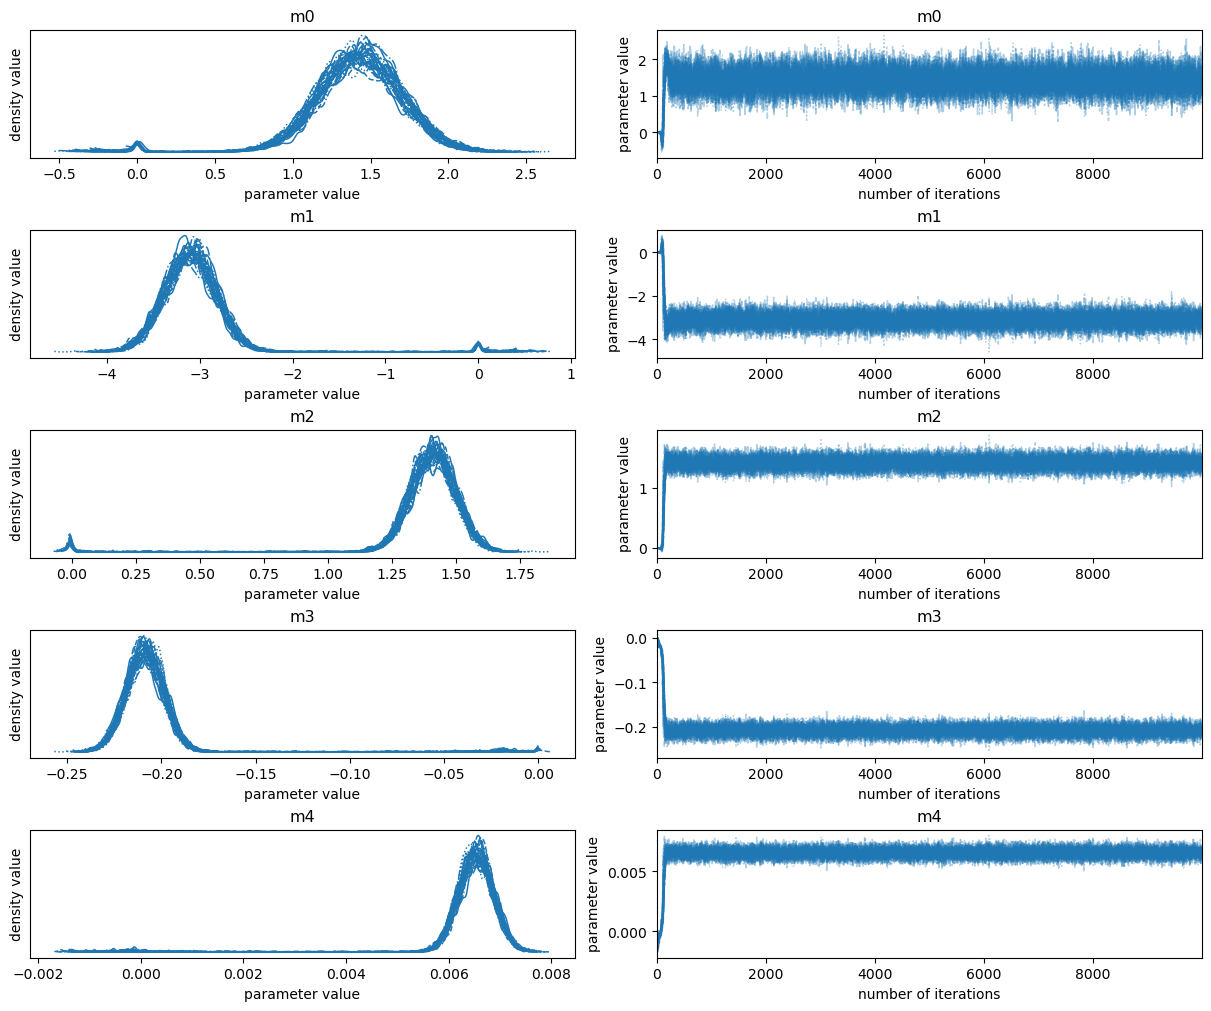

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

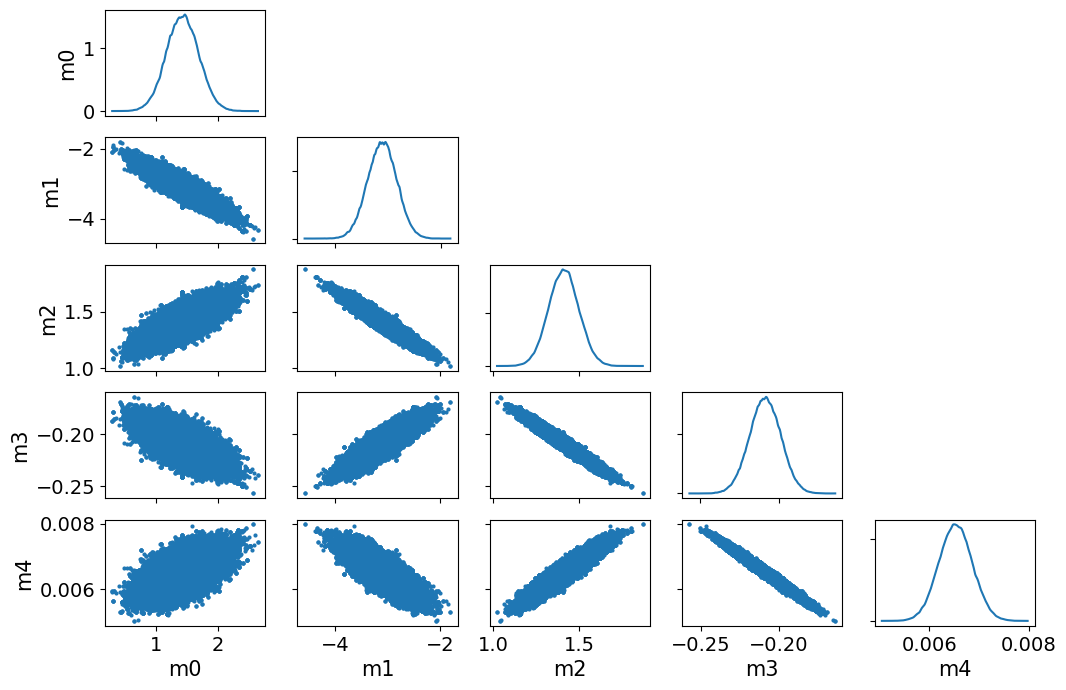

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

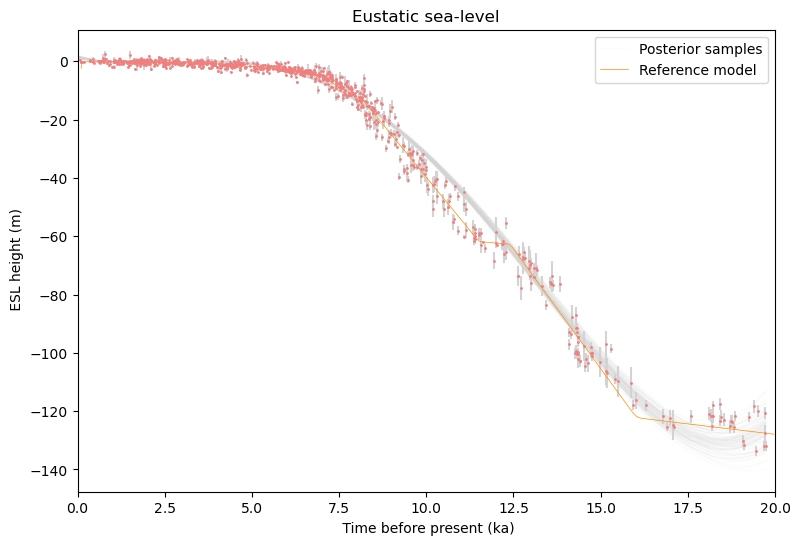

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.432 [  1.005,   1.867]
 m1  -3.103 [ -3.561,  -2.651]
 m2   1.410 [  1.267,   1.553]
 m3  -0.209 [ -0.225,  -0.192]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.89297627e-02 -6.47039149e-02  1.72546761e-02 -1.65820144e-03
   4.89630154e-05]
 [-6.47039149e-02  7.62235591e-02 -2.29108465e-02  2.37957625e-03
  -7.36879903e-05]
 [ 1.72546761e-02 -2.29108465e-02  7.55121761e-03 -8.38163511e-04
   2.70307677e-05]
 [-1.65820144e-03  2.37957625e-03 -8.38163511e-04  9.80704926e-05
  -3.27092519e-06]
 [ 4.89630154e-05 -7.36879903e-05  2.70307677e-05 -3.27092519e-06
   1.12043726e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2625
    m1  0.2761
    m2  0.0869
    m3  0.0099
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                         | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                              | 14/10000 [00:00<01:13, 135.04it/s]

  0%|▍                                                                                                                                              | 28/10000 [00:00<01:13, 135.62it/s]

  0%|▌                                                                                                                                              | 42/10000 [00:00<01:13, 136.18it/s]

  1%|▊                                                                                                                                              | 56/10000 [00:00<01:13, 136.08it/s]

  1%|█                                                                                                                                              | 70/10000 [00:00<01:12, 136.69it/s]

  1%|█▏                                                                                                                                             | 84/10000 [00:00<01:12, 136.73it/s]

  1%|█▍                                                                                                                                             | 98/10000 [00:00<01:13, 134.76it/s]

  1%|█▌                                                                                                                                            | 112/10000 [00:00<01:12, 135.50it/s]

  1%|█▊                                                                                                                                            | 126/10000 [00:00<01:12, 135.91it/s]

  1%|█▉                                                                                                                                            | 140/10000 [00:01<01:12, 136.42it/s]

  2%|██▏                                                                                                                                           | 154/10000 [00:01<01:11, 136.83it/s]

  2%|██▍                                                                                                                                           | 168/10000 [00:01<01:11, 137.20it/s]

  2%|██▌                                                                                                                                           | 182/10000 [00:01<01:11, 137.40it/s]

  2%|██▊                                                                                                                                           | 196/10000 [00:01<01:11, 137.53it/s]

  2%|██▉                                                                                                                                           | 210/10000 [00:01<01:11, 137.65it/s]

  2%|███▏                                                                                                                                          | 224/10000 [00:01<01:10, 137.70it/s]

  2%|███▍                                                                                                                                          | 238/10000 [00:01<01:10, 137.71it/s]

  3%|███▌                                                                                                                                          | 252/10000 [00:01<01:10, 137.73it/s]

  3%|███▊                                                                                                                                          | 266/10000 [00:01<01:10, 137.74it/s]

  3%|███▉                                                                                                                                          | 280/10000 [00:02<01:24, 115.56it/s]

  3%|████▏                                                                                                                                         | 294/10000 [00:02<01:19, 121.34it/s]

  3%|████▎                                                                                                                                         | 308/10000 [00:02<01:18, 124.03it/s]

  3%|████▌                                                                                                                                         | 322/10000 [00:02<01:15, 127.73it/s]

  3%|████▊                                                                                                                                         | 336/10000 [00:02<01:15, 128.47it/s]

  4%|████▉                                                                                                                                         | 350/10000 [00:02<01:13, 131.16it/s]

  4%|█████▏                                                                                                                                        | 364/10000 [00:02<01:12, 133.28it/s]

  4%|█████▎                                                                                                                                        | 378/10000 [00:02<01:12, 132.83it/s]

  4%|█████▌                                                                                                                                        | 392/10000 [00:02<01:11, 134.25it/s]

  4%|█████▊                                                                                                                                        | 406/10000 [00:03<01:11, 135.12it/s]

  4%|█████▉                                                                                                                                        | 420/10000 [00:03<01:11, 134.79it/s]

  4%|██████▏                                                                                                                                       | 434/10000 [00:03<01:11, 134.30it/s]

  4%|██████▎                                                                                                                                       | 448/10000 [00:03<01:10, 135.73it/s]

  5%|██████▌                                                                                                                                       | 463/10000 [00:03<01:09, 137.19it/s]

  5%|██████▊                                                                                                                                       | 477/10000 [00:03<01:09, 137.82it/s]

  5%|██████▉                                                                                                                                       | 491/10000 [00:03<01:09, 136.54it/s]

  5%|███████▏                                                                                                                                      | 505/10000 [00:03<01:09, 137.39it/s]

  5%|███████▍                                                                                                                                      | 520/10000 [00:03<01:08, 138.32it/s]

  5%|███████▌                                                                                                                                      | 534/10000 [00:03<01:08, 138.71it/s]

  5%|███████▊                                                                                                                                      | 548/10000 [00:04<01:08, 138.54it/s]

  6%|███████▉                                                                                                                                      | 562/10000 [00:04<01:07, 138.81it/s]

  6%|████████▏                                                                                                                                     | 576/10000 [00:04<01:07, 139.06it/s]

  6%|████████▍                                                                                                                                     | 590/10000 [00:04<01:07, 139.24it/s]

  6%|████████▌                                                                                                                                     | 604/10000 [00:04<01:07, 139.33it/s]

  6%|████████▊                                                                                                                                     | 618/10000 [00:04<01:07, 139.36it/s]

  6%|████████▉                                                                                                                                     | 632/10000 [00:04<01:07, 139.42it/s]

  6%|█████████▏                                                                                                                                    | 646/10000 [00:04<01:07, 139.51it/s]

  7%|█████████▎                                                                                                                                    | 660/10000 [00:04<01:07, 138.61it/s]

  7%|█████████▌                                                                                                                                    | 674/10000 [00:04<01:07, 138.74it/s]

  7%|█████████▊                                                                                                                                    | 688/10000 [00:05<01:07, 138.25it/s]

  7%|█████████▉                                                                                                                                    | 702/10000 [00:05<01:07, 137.96it/s]

  7%|██████████▏                                                                                                                                   | 716/10000 [00:05<01:07, 137.85it/s]

  7%|██████████▎                                                                                                                                   | 730/10000 [00:05<01:07, 136.76it/s]

  7%|██████████▌                                                                                                                                   | 744/10000 [00:05<01:10, 131.50it/s]

  8%|██████████▊                                                                                                                                   | 758/10000 [00:05<01:24, 109.14it/s]

  8%|██████████▉                                                                                                                                   | 770/10000 [00:05<01:29, 103.26it/s]

  8%|███████████                                                                                                                                   | 781/10000 [00:05<01:30, 101.34it/s]

  8%|███████████▎                                                                                                                                  | 795/10000 [00:06<01:23, 110.59it/s]

  8%|███████████▍                                                                                                                                  | 809/10000 [00:06<01:17, 118.02it/s]

  8%|███████████▋                                                                                                                                  | 823/10000 [00:06<01:14, 122.95it/s]

  8%|███████████▉                                                                                                                                  | 837/10000 [00:06<01:13, 125.39it/s]

  9%|████████████                                                                                                                                  | 851/10000 [00:06<01:10, 129.04it/s]

  9%|████████████▎                                                                                                                                 | 865/10000 [00:06<01:09, 131.73it/s]

  9%|████████████▍                                                                                                                                 | 879/10000 [00:06<01:08, 133.71it/s]

  9%|████████████▋                                                                                                                                 | 893/10000 [00:06<01:08, 133.36it/s]

  9%|████████████▉                                                                                                                                 | 907/10000 [00:06<01:07, 134.71it/s]

  9%|█████████████                                                                                                                                 | 921/10000 [00:06<01:06, 135.99it/s]

  9%|█████████████▎                                                                                                                                | 935/10000 [00:07<01:06, 137.06it/s]

  9%|█████████████▍                                                                                                                                | 949/10000 [00:07<01:05, 137.92it/s]

 10%|█████████████▋                                                                                                                                | 963/10000 [00:07<01:05, 138.52it/s]

 10%|█████████████▊                                                                                                                                | 977/10000 [00:07<01:05, 138.53it/s]

 10%|██████████████                                                                                                                                | 991/10000 [00:07<01:05, 138.46it/s]

 10%|██████████████▏                                                                                                                              | 1005/10000 [00:07<01:05, 138.21it/s]

 10%|██████████████▎                                                                                                                              | 1019/10000 [00:07<01:05, 138.09it/s]

 10%|██████████████▌                                                                                                                              | 1033/10000 [00:07<01:04, 138.25it/s]

 10%|██████████████▊                                                                                                                              | 1047/10000 [00:07<01:04, 138.40it/s]

 11%|██████████████▉                                                                                                                              | 1061/10000 [00:07<01:04, 138.61it/s]

 11%|███████████████▏                                                                                                                             | 1075/10000 [00:08<01:04, 137.89it/s]

 11%|███████████████▎                                                                                                                             | 1089/10000 [00:08<01:04, 138.18it/s]

 11%|███████████████▌                                                                                                                             | 1103/10000 [00:08<01:04, 138.40it/s]

 11%|███████████████▋                                                                                                                             | 1117/10000 [00:08<01:04, 138.52it/s]

 11%|███████████████▉                                                                                                                             | 1131/10000 [00:08<01:03, 138.67it/s]

 11%|████████████████▏                                                                                                                            | 1145/10000 [00:08<01:03, 138.79it/s]

 12%|████████████████▎                                                                                                                            | 1159/10000 [00:08<01:03, 138.91it/s]

 12%|████████████████▌                                                                                                                            | 1173/10000 [00:08<01:03, 138.87it/s]

 12%|████████████████▋                                                                                                                            | 1187/10000 [00:08<01:03, 138.77it/s]

 12%|████████████████▉                                                                                                                            | 1201/10000 [00:08<01:03, 138.57it/s]

 12%|█████████████████▏                                                                                                                           | 1215/10000 [00:09<01:03, 138.44it/s]

 12%|█████████████████▎                                                                                                                           | 1229/10000 [00:09<01:03, 138.41it/s]

 12%|█████████████████▌                                                                                                                           | 1243/10000 [00:09<01:03, 138.42it/s]

 13%|█████████████████▋                                                                                                                           | 1257/10000 [00:09<01:03, 138.27it/s]

 13%|█████████████████▉                                                                                                                           | 1271/10000 [00:09<01:03, 138.35it/s]

 13%|██████████████████                                                                                                                           | 1285/10000 [00:09<01:02, 138.36it/s]

 13%|██████████████████▎                                                                                                                          | 1299/10000 [00:09<01:03, 136.47it/s]

 13%|██████████████████▌                                                                                                                          | 1313/10000 [00:09<01:03, 137.37it/s]

 13%|██████████████████▋                                                                                                                          | 1327/10000 [00:09<01:03, 137.24it/s]

 13%|██████████████████▉                                                                                                                          | 1341/10000 [00:09<01:02, 138.03it/s]

 14%|███████████████████                                                                                                                          | 1356/10000 [00:10<01:02, 138.72it/s]

 14%|███████████████████▎                                                                                                                         | 1371/10000 [00:10<01:01, 139.21it/s]

 14%|███████████████████▌                                                                                                                         | 1385/10000 [00:10<01:01, 139.42it/s]

 14%|███████████████████▋                                                                                                                         | 1399/10000 [00:10<01:01, 139.56it/s]

 14%|███████████████████▉                                                                                                                         | 1414/10000 [00:10<01:01, 139.79it/s]

 14%|████████████████████▏                                                                                                                        | 1428/10000 [00:10<01:01, 138.53it/s]

 14%|████████████████████▎                                                                                                                        | 1443/10000 [00:10<01:01, 139.03it/s]

 15%|████████████████████▌                                                                                                                        | 1457/10000 [00:10<01:01, 139.04it/s]

 15%|████████████████████▋                                                                                                                        | 1471/10000 [00:10<01:01, 138.99it/s]

 15%|████████████████████▉                                                                                                                        | 1485/10000 [00:11<01:01, 138.37it/s]

 15%|█████████████████████▏                                                                                                                       | 1499/10000 [00:11<01:01, 138.63it/s]

 15%|█████████████████████▎                                                                                                                       | 1513/10000 [00:11<01:01, 138.71it/s]

 15%|█████████████████████▌                                                                                                                       | 1527/10000 [00:11<01:01, 138.69it/s]

 15%|█████████████████████▋                                                                                                                       | 1541/10000 [00:11<01:01, 136.53it/s]

 16%|█████████████████████▉                                                                                                                       | 1555/10000 [00:11<01:01, 137.30it/s]

 16%|██████████████████████                                                                                                                       | 1569/10000 [00:11<01:02, 135.55it/s]

 16%|██████████████████████▎                                                                                                                      | 1583/10000 [00:11<01:01, 136.82it/s]

 16%|██████████████████████▌                                                                                                                      | 1597/10000 [00:11<01:02, 135.35it/s]

 16%|██████████████████████▋                                                                                                                      | 1611/10000 [00:11<01:01, 136.39it/s]

 16%|██████████████████████▉                                                                                                                      | 1625/10000 [00:12<01:01, 137.06it/s]

 16%|███████████████████████                                                                                                                      | 1639/10000 [00:12<01:00, 137.16it/s]

 17%|███████████████████████▎                                                                                                                     | 1653/10000 [00:12<01:00, 137.71it/s]

 17%|███████████████████████▌                                                                                                                     | 1667/10000 [00:12<01:01, 135.79it/s]

 17%|███████████████████████▋                                                                                                                     | 1681/10000 [00:12<01:00, 136.52it/s]

 17%|███████████████████████▉                                                                                                                     | 1695/10000 [00:12<01:00, 136.96it/s]

 17%|████████████████████████                                                                                                                     | 1709/10000 [00:12<01:01, 135.63it/s]

 17%|████████████████████████▎                                                                                                                    | 1723/10000 [00:12<01:00, 135.80it/s]

 17%|████████████████████████▍                                                                                                                    | 1737/10000 [00:12<01:00, 136.44it/s]

 18%|████████████████████████▋                                                                                                                    | 1751/10000 [00:12<01:00, 137.04it/s]

 18%|████████████████████████▉                                                                                                                    | 1765/10000 [00:13<00:59, 137.38it/s]

 18%|█████████████████████████                                                                                                                    | 1779/10000 [00:13<00:59, 137.49it/s]

 18%|█████████████████████████▎                                                                                                                   | 1793/10000 [00:13<00:59, 138.10it/s]

 18%|█████████████████████████▍                                                                                                                   | 1807/10000 [00:13<00:59, 138.57it/s]

 18%|█████████████████████████▋                                                                                                                   | 1822/10000 [00:13<00:58, 139.16it/s]

 18%|█████████████████████████▉                                                                                                                   | 1837/10000 [00:13<00:58, 139.59it/s]

 19%|██████████████████████████                                                                                                                   | 1852/10000 [00:13<00:58, 139.77it/s]

 19%|██████████████████████████▎                                                                                                                  | 1867/10000 [00:13<00:58, 139.88it/s]

 19%|██████████████████████████▌                                                                                                                  | 1881/10000 [00:13<00:58, 139.82it/s]

 19%|██████████████████████████▋                                                                                                                  | 1895/10000 [00:14<00:58, 139.73it/s]

 19%|██████████████████████████▉                                                                                                                  | 1909/10000 [00:14<00:57, 139.78it/s]

 19%|███████████████████████████                                                                                                                  | 1923/10000 [00:14<00:57, 139.78it/s]

 19%|███████████████████████████▎                                                                                                                 | 1937/10000 [00:14<00:57, 139.46it/s]

 20%|███████████████████████████▌                                                                                                                 | 1951/10000 [00:14<00:58, 138.70it/s]

 20%|███████████████████████████▋                                                                                                                 | 1965/10000 [00:14<00:57, 139.00it/s]

 20%|███████████████████████████▉                                                                                                                 | 1979/10000 [00:14<00:57, 138.98it/s]

 20%|████████████████████████████                                                                                                                 | 1993/10000 [00:14<00:57, 138.97it/s]

 20%|████████████████████████████▎                                                                                                                | 2007/10000 [00:14<00:57, 138.06it/s]

 20%|████████████████████████████▍                                                                                                                | 2021/10000 [00:14<00:57, 138.05it/s]

 20%|████████████████████████████▋                                                                                                                | 2035/10000 [00:15<00:57, 138.07it/s]

 20%|████████████████████████████▉                                                                                                                | 2049/10000 [00:15<00:57, 138.14it/s]

 21%|█████████████████████████████                                                                                                                | 2063/10000 [00:15<00:57, 138.35it/s]

 21%|█████████████████████████████▎                                                                                                               | 2077/10000 [00:15<00:57, 138.45it/s]

 21%|█████████████████████████████▍                                                                                                               | 2091/10000 [00:15<00:57, 136.39it/s]

 21%|█████████████████████████████▋                                                                                                               | 2105/10000 [00:15<00:57, 136.99it/s]

 21%|█████████████████████████████▉                                                                                                               | 2119/10000 [00:15<00:57, 137.21it/s]

 21%|██████████████████████████████                                                                                                               | 2133/10000 [00:15<00:58, 135.32it/s]

 21%|██████████████████████████████▎                                                                                                              | 2147/10000 [00:15<00:57, 136.61it/s]

 22%|██████████████████████████████▍                                                                                                              | 2161/10000 [00:15<00:56, 137.58it/s]

 22%|██████████████████████████████▋                                                                                                              | 2175/10000 [00:16<00:56, 138.11it/s]

 22%|██████████████████████████████▊                                                                                                              | 2189/10000 [00:16<00:56, 138.46it/s]

 22%|███████████████████████████████                                                                                                              | 2203/10000 [00:16<00:56, 137.98it/s]

 22%|███████████████████████████████▎                                                                                                             | 2217/10000 [00:16<00:56, 138.54it/s]

 22%|███████████████████████████████▍                                                                                                             | 2232/10000 [00:16<00:55, 139.02it/s]

 22%|███████████████████████████████▋                                                                                                             | 2247/10000 [00:16<00:55, 139.46it/s]

 23%|███████████████████████████████▉                                                                                                             | 2262/10000 [00:16<00:55, 139.69it/s]

 23%|████████████████████████████████                                                                                                             | 2276/10000 [00:16<01:02, 124.48it/s]

 23%|████████████████████████████████▎                                                                                                            | 2289/10000 [00:16<01:02, 124.12it/s]

 23%|████████████████████████████████▍                                                                                                            | 2304/10000 [00:17<00:59, 128.78it/s]

 23%|████████████████████████████████▋                                                                                                            | 2318/10000 [00:17<00:58, 131.24it/s]

 23%|████████████████████████████████▉                                                                                                            | 2332/10000 [00:17<00:57, 133.68it/s]

 23%|█████████████████████████████████                                                                                                            | 2346/10000 [00:17<01:09, 110.15it/s]

 24%|█████████████████████████████████▏                                                                                                           | 2358/10000 [00:17<01:12, 106.10it/s]

 24%|█████████████████████████████████▍                                                                                                           | 2370/10000 [00:17<01:13, 103.37it/s]

 24%|█████████████████████████████████▊                                                                                                            | 2381/10000 [00:17<01:22, 91.92it/s]

 24%|█████████████████████████████████▉                                                                                                            | 2391/10000 [00:17<01:29, 84.61it/s]

 24%|██████████████████████████████████▏                                                                                                           | 2404/10000 [00:18<01:19, 95.15it/s]

 24%|██████████████████████████████████                                                                                                           | 2418/10000 [00:18<01:11, 106.03it/s]

 24%|██████████████████████████████████▎                                                                                                          | 2430/10000 [00:18<01:09, 108.99it/s]

 24%|██████████████████████████████████▍                                                                                                          | 2444/10000 [00:18<01:04, 117.10it/s]

 25%|██████████████████████████████████▋                                                                                                          | 2458/10000 [00:18<01:01, 123.05it/s]

 25%|██████████████████████████████████▊                                                                                                          | 2472/10000 [00:18<00:58, 127.70it/s]

 25%|███████████████████████████████████                                                                                                          | 2486/10000 [00:18<00:58, 128.70it/s]

 25%|███████████████████████████████████▎                                                                                                         | 2500/10000 [00:18<00:56, 131.59it/s]

 25%|███████████████████████████████████▍                                                                                                         | 2514/10000 [00:18<00:59, 126.44it/s]

 25%|███████████████████████████████████▋                                                                                                         | 2527/10000 [00:18<01:01, 121.38it/s]

 25%|███████████████████████████████████▊                                                                                                         | 2540/10000 [00:19<01:06, 111.44it/s]

 26%|████████████████████████████████████▏                                                                                                         | 2552/10000 [00:19<01:17, 95.71it/s]

 26%|████████████████████████████████████▏                                                                                                        | 2566/10000 [00:19<01:10, 105.16it/s]

 26%|████████████████████████████████████▎                                                                                                        | 2579/10000 [00:19<01:08, 107.85it/s]

 26%|████████████████████████████████████▊                                                                                                         | 2591/10000 [00:19<01:14, 99.46it/s]

 26%|████████████████████████████████████▉                                                                                                         | 2602/10000 [00:19<01:20, 92.08it/s]

 26%|████████████████████████████████████▊                                                                                                        | 2615/10000 [00:19<01:13, 101.14it/s]

 26%|█████████████████████████████████████                                                                                                        | 2629/10000 [00:20<01:07, 109.92it/s]

 26%|█████████████████████████████████████▎                                                                                                       | 2643/10000 [00:20<01:02, 117.52it/s]

 27%|█████████████████████████████████████▍                                                                                                       | 2657/10000 [00:20<00:59, 123.46it/s]

 27%|█████████████████████████████████████▋                                                                                                       | 2671/10000 [00:20<00:57, 127.83it/s]

 27%|█████████████████████████████████████▊                                                                                                       | 2685/10000 [00:20<00:55, 131.00it/s]

 27%|██████████████████████████████████████                                                                                                       | 2699/10000 [00:20<00:54, 133.37it/s]

 27%|██████████████████████████████████████▎                                                                                                      | 2713/10000 [00:20<00:54, 134.90it/s]

 27%|██████████████████████████████████████▍                                                                                                      | 2727/10000 [00:20<00:53, 135.94it/s]

 27%|██████████████████████████████████████▋                                                                                                      | 2741/10000 [00:20<01:08, 106.34it/s]

 28%|██████████████████████████████████████▊                                                                                                      | 2755/10000 [00:21<01:03, 113.49it/s]

 28%|███████████████████████████████████████                                                                                                      | 2768/10000 [00:21<01:03, 113.78it/s]

 28%|███████████████████████████████████████▏                                                                                                     | 2782/10000 [00:21<00:59, 120.48it/s]

 28%|███████████████████████████████████████▍                                                                                                     | 2796/10000 [00:21<00:57, 125.65it/s]

 28%|███████████████████████████████████████▌                                                                                                     | 2810/10000 [00:21<00:55, 129.55it/s]

 28%|███████████████████████████████████████▊                                                                                                     | 2824/10000 [00:21<00:54, 132.25it/s]

 28%|████████████████████████████████████████                                                                                                     | 2839/10000 [00:21<00:53, 132.89it/s]

 29%|████████████████████████████████████████▏                                                                                                    | 2853/10000 [00:21<00:53, 134.80it/s]

 29%|████████████████████████████████████████▍                                                                                                    | 2867/10000 [00:21<00:52, 135.99it/s]

 29%|████████████████████████████████████████▌                                                                                                    | 2881/10000 [00:21<00:52, 136.82it/s]

 29%|████████████████████████████████████████▊                                                                                                    | 2895/10000 [00:22<00:51, 137.46it/s]

 29%|█████████████████████████████████████████                                                                                                    | 2909/10000 [00:22<00:51, 138.04it/s]

 29%|█████████████████████████████████████████▏                                                                                                   | 2923/10000 [00:22<00:51, 138.52it/s]

 29%|█████████████████████████████████████████▍                                                                                                   | 2937/10000 [00:22<00:50, 138.80it/s]

 30%|█████████████████████████████████████████▌                                                                                                   | 2951/10000 [00:22<00:50, 139.01it/s]

 30%|█████████████████████████████████████████▊                                                                                                   | 2965/10000 [00:22<00:50, 138.70it/s]

 30%|██████████████████████████████████████████                                                                                                   | 2979/10000 [00:22<00:50, 138.78it/s]

 30%|██████████████████████████████████████████▏                                                                                                  | 2993/10000 [00:22<00:50, 138.88it/s]

 30%|██████████████████████████████████████████▍                                                                                                  | 3007/10000 [00:22<00:50, 139.01it/s]

 30%|██████████████████████████████████████████▌                                                                                                  | 3021/10000 [00:22<00:50, 138.41it/s]

 30%|██████████████████████████████████████████▊                                                                                                  | 3035/10000 [00:23<00:50, 138.30it/s]

 30%|██████████████████████████████████████████▉                                                                                                  | 3049/10000 [00:23<00:50, 138.43it/s]

 31%|███████████████████████████████████████████▏                                                                                                 | 3063/10000 [00:23<00:50, 138.25it/s]

 31%|███████████████████████████████████████████▍                                                                                                 | 3077/10000 [00:23<00:49, 138.62it/s]

 31%|███████████████████████████████████████████▌                                                                                                 | 3091/10000 [00:23<00:50, 136.54it/s]

 31%|███████████████████████████████████████████▊                                                                                                 | 3105/10000 [00:23<00:50, 137.08it/s]

 31%|███████████████████████████████████████████▉                                                                                                 | 3119/10000 [00:23<00:50, 137.15it/s]

 31%|████████████████████████████████████████████▏                                                                                                | 3133/10000 [00:23<00:49, 137.42it/s]

 31%|████████████████████████████████████████████▎                                                                                                | 3147/10000 [00:23<00:49, 137.44it/s]

 32%|████████████████████████████████████████████▌                                                                                                | 3161/10000 [00:23<00:49, 137.72it/s]

 32%|████████████████████████████████████████████▊                                                                                                | 3175/10000 [00:24<00:49, 137.93it/s]

 32%|████████████████████████████████████████████▉                                                                                                | 3189/10000 [00:24<00:49, 137.35it/s]

 32%|█████████████████████████████████████████████▏                                                                                               | 3203/10000 [00:24<00:49, 137.36it/s]

 32%|█████████████████████████████████████████████▎                                                                                               | 3217/10000 [00:24<00:50, 135.14it/s]

 32%|█████████████████████████████████████████████▌                                                                                               | 3231/10000 [00:24<00:49, 136.07it/s]

 32%|█████████████████████████████████████████████▊                                                                                               | 3245/10000 [00:24<00:49, 136.64it/s]

 33%|█████████████████████████████████████████████▉                                                                                               | 3259/10000 [00:24<00:49, 135.49it/s]

 33%|██████████████████████████████████████████████▏                                                                                              | 3273/10000 [00:24<00:49, 136.53it/s]

 33%|██████████████████████████████████████████████▎                                                                                              | 3287/10000 [00:24<00:49, 135.56it/s]

 33%|██████████████████████████████████████████████▌                                                                                              | 3301/10000 [00:25<00:49, 135.61it/s]

 33%|██████████████████████████████████████████████▋                                                                                              | 3315/10000 [00:25<00:49, 136.03it/s]

 33%|██████████████████████████████████████████████▉                                                                                              | 3329/10000 [00:25<00:48, 136.33it/s]

 33%|███████████████████████████████████████████████▏                                                                                             | 3343/10000 [00:25<00:48, 136.54it/s]

 34%|███████████████████████████████████████████████▎                                                                                             | 3357/10000 [00:25<00:48, 137.01it/s]

 34%|███████████████████████████████████████████████▌                                                                                             | 3371/10000 [00:25<00:48, 137.32it/s]

 34%|███████████████████████████████████████████████▋                                                                                             | 3385/10000 [00:25<00:48, 137.18it/s]

 34%|███████████████████████████████████████████████▉                                                                                             | 3399/10000 [00:25<00:48, 137.49it/s]

 34%|████████████████████████████████████████████████                                                                                             | 3413/10000 [00:25<00:47, 137.71it/s]

 34%|████████████████████████████████████████████████▎                                                                                            | 3427/10000 [00:25<00:47, 137.81it/s]

 34%|████████████████████████████████████████████████▌                                                                                            | 3441/10000 [00:26<00:47, 137.80it/s]

 35%|████████████████████████████████████████████████▋                                                                                            | 3455/10000 [00:26<00:47, 138.18it/s]

 35%|████████████████████████████████████████████████▉                                                                                            | 3469/10000 [00:26<00:47, 137.84it/s]

 35%|█████████████████████████████████████████████████                                                                                            | 3483/10000 [00:26<00:47, 138.02it/s]

 35%|█████████████████████████████████████████████████▎                                                                                           | 3497/10000 [00:26<00:47, 137.96it/s]

 35%|█████████████████████████████████████████████████▌                                                                                           | 3511/10000 [00:26<00:46, 138.16it/s]

 35%|█████████████████████████████████████████████████▋                                                                                           | 3525/10000 [00:26<00:46, 138.15it/s]

 35%|█████████████████████████████████████████████████▉                                                                                           | 3539/10000 [00:26<00:46, 138.43it/s]

 36%|██████████████████████████████████████████████████                                                                                           | 3553/10000 [00:26<00:46, 138.67it/s]

 36%|██████████████████████████████████████████████████▎                                                                                          | 3567/10000 [00:26<00:46, 138.78it/s]

 36%|██████████████████████████████████████████████████▍                                                                                          | 3581/10000 [00:27<00:46, 138.70it/s]

 36%|██████████████████████████████████████████████████▋                                                                                          | 3595/10000 [00:27<00:46, 138.68it/s]

 36%|██████████████████████████████████████████████████▉                                                                                          | 3609/10000 [00:27<00:46, 138.56it/s]

 36%|███████████████████████████████████████████████████                                                                                          | 3623/10000 [00:27<00:46, 138.61it/s]

 36%|███████████████████████████████████████████████████▎                                                                                         | 3637/10000 [00:27<00:45, 138.72it/s]

 37%|███████████████████████████████████████████████████▍                                                                                         | 3651/10000 [00:27<00:45, 138.91it/s]

 37%|███████████████████████████████████████████████████▋                                                                                         | 3665/10000 [00:27<00:45, 138.54it/s]

 37%|███████████████████████████████████████████████████▊                                                                                         | 3679/10000 [00:27<00:46, 134.64it/s]

 37%|████████████████████████████████████████████████████                                                                                         | 3693/10000 [00:27<00:46, 134.36it/s]

 37%|████████████████████████████████████████████████████▎                                                                                        | 3707/10000 [00:27<00:46, 135.21it/s]

 37%|████████████████████████████████████████████████████▍                                                                                        | 3721/10000 [00:28<00:46, 135.73it/s]

 37%|████████████████████████████████████████████████████▋                                                                                        | 3735/10000 [00:28<00:46, 136.00it/s]

 37%|████████████████████████████████████████████████████▊                                                                                        | 3749/10000 [00:28<00:45, 136.36it/s]

 38%|█████████████████████████████████████████████████████                                                                                        | 3763/10000 [00:28<00:45, 136.44it/s]

 38%|█████████████████████████████████████████████████████▎                                                                                       | 3777/10000 [00:28<00:45, 136.76it/s]

 38%|█████████████████████████████████████████████████████▍                                                                                       | 3791/10000 [00:28<00:45, 136.56it/s]

 38%|█████████████████████████████████████████████████████▋                                                                                       | 3805/10000 [00:28<00:45, 136.93it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                       | 3819/10000 [00:28<00:44, 137.48it/s]

 38%|██████████████████████████████████████████████████████                                                                                       | 3833/10000 [00:28<00:44, 137.73it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                      | 3847/10000 [00:28<00:44, 137.87it/s]

 39%|██████████████████████████████████████████████████████▍                                                                                      | 3861/10000 [00:29<00:44, 137.67it/s]

 39%|██████████████████████████████████████████████████████▋                                                                                      | 3875/10000 [00:29<00:44, 137.59it/s]

 39%|██████████████████████████████████████████████████████▊                                                                                      | 3889/10000 [00:29<00:44, 137.75it/s]

 39%|███████████████████████████████████████████████████████                                                                                      | 3903/10000 [00:29<00:44, 137.49it/s]

 39%|███████████████████████████████████████████████████████▏                                                                                     | 3917/10000 [00:29<00:44, 137.61it/s]

 39%|███████████████████████████████████████████████████████▍                                                                                     | 3931/10000 [00:29<00:44, 137.20it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                     | 3945/10000 [00:29<00:44, 136.90it/s]

 40%|███████████████████████████████████████████████████████▊                                                                                     | 3959/10000 [00:29<00:44, 136.73it/s]

 40%|████████████████████████████████████████████████████████                                                                                     | 3973/10000 [00:29<00:44, 135.98it/s]

 40%|████████████████████████████████████████████████████████▏                                                                                    | 3987/10000 [00:30<00:44, 136.12it/s]

 40%|████████████████████████████████████████████████████████▍                                                                                    | 4001/10000 [00:30<00:56, 106.57it/s]

 40%|████████████████████████████████████████████████████████▌                                                                                    | 4015/10000 [00:30<00:52, 113.63it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                    | 4029/10000 [00:30<00:49, 119.58it/s]

 40%|█████████████████████████████████████████████████████████                                                                                    | 4043/10000 [00:30<00:47, 124.50it/s]

 41%|█████████████████████████████████████████████████████████▏                                                                                   | 4057/10000 [00:30<00:46, 128.05it/s]

 41%|█████████████████████████████████████████████████████████▍                                                                                   | 4071/10000 [00:30<00:45, 129.07it/s]

 41%|█████████████████████████████████████████████████████████▌                                                                                   | 4085/10000 [00:30<00:45, 131.42it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                   | 4099/10000 [00:30<00:44, 133.21it/s]

 41%|█████████████████████████████████████████████████████████▉                                                                                   | 4113/10000 [00:31<00:43, 134.46it/s]

 41%|██████████████████████████████████████████████████████████▏                                                                                  | 4127/10000 [00:31<00:43, 135.50it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                  | 4141/10000 [00:31<00:43, 136.22it/s]

 42%|██████████████████████████████████████████████████████████▌                                                                                  | 4155/10000 [00:31<00:42, 136.66it/s]

 42%|██████████████████████████████████████████████████████████▊                                                                                  | 4169/10000 [00:31<00:42, 137.06it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                  | 4183/10000 [00:31<00:42, 137.36it/s]

 42%|███████████████████████████████████████████████████████████▏                                                                                 | 4197/10000 [00:31<00:42, 137.75it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                 | 4211/10000 [00:31<00:42, 137.82it/s]

 42%|███████████████████████████████████████████████████████████▌                                                                                 | 4225/10000 [00:31<00:41, 138.11it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                 | 4239/10000 [00:31<00:41, 138.41it/s]

 43%|███████████████████████████████████████████████████████████▉                                                                                 | 4253/10000 [00:32<00:41, 138.43it/s]

 43%|████████████████████████████████████████████████████████████▏                                                                                | 4267/10000 [00:32<00:41, 138.65it/s]

 43%|████████████████████████████████████████████████████████████▎                                                                                | 4281/10000 [00:32<00:41, 138.74it/s]

 43%|████████████████████████████████████████████████████████████▌                                                                                | 4295/10000 [00:32<00:41, 138.78it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                | 4309/10000 [00:32<00:40, 138.93it/s]

 43%|████████████████████████████████████████████████████████████▉                                                                                | 4323/10000 [00:32<00:40, 139.03it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                               | 4337/10000 [00:32<00:40, 139.09it/s]

 44%|█████████████████████████████████████████████████████████████▎                                                                               | 4351/10000 [00:32<00:40, 139.07it/s]

 44%|█████████████████████████████████████████████████████████████▌                                                                               | 4365/10000 [00:32<00:40, 139.05it/s]

 44%|█████████████████████████████████████████████████████████████▋                                                                               | 4379/10000 [00:32<00:40, 138.89it/s]

 44%|█████████████████████████████████████████████████████████████▉                                                                               | 4393/10000 [00:33<00:40, 138.65it/s]

 44%|██████████████████████████████████████████████████████████████▏                                                                              | 4407/10000 [00:33<00:40, 138.68it/s]

 44%|██████████████████████████████████████████████████████████████▎                                                                              | 4421/10000 [00:33<00:40, 138.56it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                              | 4435/10000 [00:33<00:40, 138.20it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                              | 4449/10000 [00:33<00:40, 137.86it/s]

 45%|██████████████████████████████████████████████████████████████▉                                                                              | 4463/10000 [00:33<00:40, 137.71it/s]

 45%|███████████████████████████████████████████████████████████████▏                                                                             | 4477/10000 [00:33<00:40, 135.79it/s]

 45%|███████████████████████████████████████████████████████████████▎                                                                             | 4491/10000 [00:33<00:40, 136.09it/s]

 45%|███████████████████████████████████████████████████████████████▌                                                                             | 4505/10000 [00:33<00:40, 136.32it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                             | 4519/10000 [00:33<00:40, 136.43it/s]

 45%|███████████████████████████████████████████████████████████████▉                                                                             | 4533/10000 [00:34<00:40, 136.47it/s]

 45%|████████████████████████████████████████████████████████████████                                                                             | 4547/10000 [00:34<00:39, 136.50it/s]

 46%|████████████████████████████████████████████████████████████████▎                                                                            | 4561/10000 [00:34<00:39, 136.69it/s]

 46%|████████████████████████████████████████████████████████████████▌                                                                            | 4575/10000 [00:34<00:39, 136.70it/s]

 46%|████████████████████████████████████████████████████████████████▋                                                                            | 4589/10000 [00:34<00:39, 136.95it/s]

 46%|████████████████████████████████████████████████████████████████▉                                                                            | 4603/10000 [00:34<00:39, 137.78it/s]

 46%|█████████████████████████████████████████████████████████████████                                                                            | 4617/10000 [00:34<00:38, 138.23it/s]

 46%|█████████████████████████████████████████████████████████████████▎                                                                           | 4632/10000 [00:34<00:38, 138.81it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                           | 4646/10000 [00:34<00:38, 137.99it/s]

 47%|█████████████████████████████████████████████████████████████████▋                                                                           | 4660/10000 [00:34<00:38, 138.25it/s]

 47%|█████████████████████████████████████████████████████████████████▉                                                                           | 4674/10000 [00:35<00:38, 138.48it/s]

 47%|██████████████████████████████████████████████████████████████████                                                                           | 4688/10000 [00:35<00:38, 138.67it/s]

 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 4702/10000 [00:35<00:38, 138.96it/s]

 47%|██████████████████████████████████████████████████████████████████▍                                                                          | 4716/10000 [00:35<00:38, 138.78it/s]

 47%|██████████████████████████████████████████████████████████████████▋                                                                          | 4730/10000 [00:35<00:37, 138.89it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                          | 4744/10000 [00:35<00:37, 138.91it/s]

 48%|███████████████████████████████████████████████████████████████████                                                                          | 4758/10000 [00:35<00:37, 139.15it/s]

 48%|███████████████████████████████████████████████████████████████████▎                                                                         | 4772/10000 [00:35<00:37, 139.21it/s]

 48%|███████████████████████████████████████████████████████████████████▍                                                                         | 4786/10000 [00:35<00:37, 139.32it/s]

 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 4800/10000 [00:36<00:37, 139.17it/s]

 48%|███████████████████████████████████████████████████████████████████▉                                                                         | 4814/10000 [00:36<00:37, 138.75it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                         | 4828/10000 [00:36<00:37, 137.59it/s]

 48%|████████████████████████████████████████████████████████████████████▎                                                                        | 4842/10000 [00:36<00:38, 135.56it/s]

 49%|████████████████████████████████████████████████████████████████████▍                                                                        | 4856/10000 [00:36<00:37, 136.01it/s]

 49%|████████████████████████████████████████████████████████████████████▋                                                                        | 4870/10000 [00:36<00:37, 136.64it/s]

 49%|████████████████████████████████████████████████████████████████████▊                                                                        | 4884/10000 [00:36<00:37, 137.04it/s]

 49%|█████████████████████████████████████████████████████████████████████                                                                        | 4898/10000 [00:36<00:37, 135.55it/s]

 49%|█████████████████████████████████████████████████████████████████████▎                                                                       | 4912/10000 [00:36<00:41, 123.27it/s]

 49%|█████████████████████████████████████████████████████████████████████▍                                                                       | 4926/10000 [00:36<00:39, 127.63it/s]

 49%|█████████████████████████████████████████████████████████████████████▋                                                                       | 4940/10000 [00:37<00:38, 130.94it/s]

 50%|█████████████████████████████████████████████████████████████████████▊                                                                       | 4954/10000 [00:37<00:37, 133.43it/s]

 50%|██████████████████████████████████████████████████████████████████████                                                                       | 4968/10000 [00:37<00:37, 135.08it/s]

 50%|██████████████████████████████████████████████████████████████████████▏                                                                      | 4982/10000 [00:37<00:36, 135.80it/s]

 50%|██████████████████████████████████████████████████████████████████████▍                                                                      | 4996/10000 [00:37<00:36, 136.38it/s]

 50%|██████████████████████████████████████████████████████████████████████▋                                                                      | 5010/10000 [00:37<00:36, 137.23it/s]

 50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 5024/10000 [00:37<00:36, 137.79it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                      | 5038/10000 [00:37<00:35, 138.16it/s]

 51%|███████████████████████████████████████████████████████████████████████▏                                                                     | 5052/10000 [00:37<00:35, 138.47it/s]

 51%|███████████████████████████████████████████████████████████████████████▍                                                                     | 5066/10000 [00:37<00:35, 138.56it/s]

 51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 5080/10000 [00:38<00:35, 138.30it/s]

 51%|███████████████████████████████████████████████████████████████████████▊                                                                     | 5094/10000 [00:38<00:35, 138.08it/s]

 51%|████████████████████████████████████████████████████████████████████████                                                                     | 5108/10000 [00:38<00:37, 131.82it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                    | 5122/10000 [00:38<00:36, 133.60it/s]

 51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 5136/10000 [00:38<00:35, 135.28it/s]

 52%|████████████████████████████████████████████████████████████████████████▌                                                                    | 5150/10000 [00:38<00:35, 136.06it/s]

 52%|████████████████████████████████████████████████████████████████████████▊                                                                    | 5164/10000 [00:38<00:35, 136.64it/s]

 52%|█████████████████████████████████████████████████████████████████████████                                                                    | 5178/10000 [00:38<00:35, 137.20it/s]

 52%|█████████████████████████████████████████████████████████████████████████▏                                                                   | 5192/10000 [00:38<00:34, 137.50it/s]

 52%|█████████████████████████████████████████████████████████████████████████▍                                                                   | 5206/10000 [00:38<00:34, 137.78it/s]

 52%|█████████████████████████████████████████████████████████████████████████▌                                                                   | 5220/10000 [00:39<00:37, 126.45it/s]

 52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 5233/10000 [00:39<00:39, 121.95it/s]

 52%|█████████████████████████████████████████████████████████████████████████▉                                                                   | 5247/10000 [00:39<00:37, 126.27it/s]

 53%|██████████████████████████████████████████████████████████████████████████▏                                                                  | 5260/10000 [00:39<00:40, 118.09it/s]

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                  | 5272/10000 [00:39<00:40, 117.55it/s]

 53%|██████████████████████████████████████████████████████████████████████████▌                                                                  | 5284/10000 [00:39<00:40, 115.50it/s]

 53%|██████████████████████████████████████████████████████████████████████████▋                                                                  | 5296/10000 [00:39<00:42, 109.74it/s]

 53%|██████████████████████████████████████████████████████████████████████████▊                                                                  | 5310/10000 [00:39<00:39, 117.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                  | 5324/10000 [00:40<00:37, 123.40it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                 | 5338/10000 [00:40<00:36, 127.73it/s]

 54%|███████████████████████████████████████████████████████████████████████████▍                                                                 | 5352/10000 [00:40<00:35, 130.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████▋                                                                 | 5366/10000 [00:40<00:34, 133.13it/s]

 54%|███████████████████████████████████████████████████████████████████████████▊                                                                 | 5380/10000 [00:40<00:34, 134.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████                                                                 | 5394/10000 [00:40<00:33, 136.11it/s]

 54%|████████████████████████████████████████████████████████████████████████████▎                                                                | 5408/10000 [00:40<00:33, 136.91it/s]

 54%|████████████████████████████████████████████████████████████████████████████▍                                                                | 5422/10000 [00:40<00:33, 137.23it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                | 5436/10000 [00:40<00:33, 137.75it/s]

 55%|████████████████████████████████████████████████████████████████████████████▊                                                                | 5450/10000 [00:40<00:32, 137.98it/s]

 55%|█████████████████████████████████████████████████████████████████████████████                                                                | 5464/10000 [00:41<00:32, 138.38it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 5479/10000 [00:41<00:32, 138.94it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▍                                                               | 5493/10000 [00:41<00:32, 139.09it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▋                                                               | 5508/10000 [00:41<00:32, 139.31it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 5522/10000 [00:41<00:32, 139.34it/s]

 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 5536/10000 [00:41<00:32, 139.48it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 5550/10000 [00:41<00:31, 139.43it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 5564/10000 [00:41<00:31, 139.49it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 5578/10000 [00:41<00:31, 139.13it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 5592/10000 [00:41<00:31, 138.91it/s]

 56%|███████████████████████████████████████████████████████████████████████████████                                                              | 5606/10000 [00:42<00:31, 138.76it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▏                                                             | 5620/10000 [00:42<00:31, 138.59it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 5634/10000 [00:42<00:31, 138.52it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▋                                                             | 5648/10000 [00:42<00:31, 138.56it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 5662/10000 [00:42<00:31, 138.59it/s]

 57%|████████████████████████████████████████████████████████████████████████████████                                                             | 5676/10000 [00:42<00:31, 138.46it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 5690/10000 [00:42<00:32, 130.71it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 5704/10000 [00:42<00:35, 121.61it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▌                                                            | 5717/10000 [00:42<00:35, 121.53it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 5731/10000 [00:43<00:33, 126.28it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 5745/10000 [00:43<00:32, 130.09it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                           | 5760/10000 [00:43<00:31, 133.09it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 5774/10000 [00:43<00:31, 135.07it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                           | 5788/10000 [00:43<00:30, 136.33it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 5802/10000 [00:43<00:30, 137.36it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 5817/10000 [00:43<00:30, 138.22it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                          | 5832/10000 [00:43<00:30, 138.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                          | 5846/10000 [00:43<00:29, 139.05it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 5860/10000 [00:43<00:29, 139.24it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▊                                                          | 5874/10000 [00:44<00:29, 139.26it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████                                                          | 5889/10000 [00:44<00:29, 139.59it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 5904/10000 [00:44<00:29, 139.81it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 5918/10000 [00:44<00:29, 139.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▋                                                         | 5932/10000 [00:44<00:30, 132.91it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 5946/10000 [00:44<00:30, 133.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████                                                         | 5960/10000 [00:44<00:29, 135.01it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                        | 5974/10000 [00:44<00:29, 135.93it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 5988/10000 [00:44<00:29, 136.09it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6003/10000 [00:44<00:29, 137.42it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6018/10000 [00:45<00:28, 138.26it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████                                                        | 6032/10000 [00:45<00:28, 138.75it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6047/10000 [00:45<00:28, 139.21it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6061/10000 [00:45<00:28, 139.32it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6076/10000 [00:45<00:28, 139.70it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6090/10000 [00:45<00:27, 139.75it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 6104/10000 [00:45<00:28, 137.90it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6119/10000 [00:45<00:27, 138.71it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6133/10000 [00:45<00:27, 138.94it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6147/10000 [00:46<00:27, 138.96it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6162/10000 [00:46<00:27, 139.48it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 6176/10000 [00:46<00:27, 138.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6191/10000 [00:46<00:27, 139.35it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6206/10000 [00:46<00:27, 139.61it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6220/10000 [00:46<00:27, 139.32it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6234/10000 [00:46<00:27, 139.24it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████                                                     | 6248/10000 [00:46<00:27, 134.94it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6262/10000 [00:46<00:27, 136.09it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6276/10000 [00:46<00:27, 136.56it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6290/10000 [00:47<00:27, 136.90it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6304/10000 [00:47<00:26, 137.06it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                    | 6318/10000 [00:47<00:31, 117.04it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6331/10000 [00:47<00:37, 98.06it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6345/10000 [00:47<00:34, 106.29it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6359/10000 [00:47<00:31, 114.37it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6373/10000 [00:47<00:30, 120.71it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 6387/10000 [00:47<00:28, 125.36it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6401/10000 [00:48<00:27, 129.01it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6415/10000 [00:48<00:27, 131.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6429/10000 [00:48<00:26, 133.98it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6443/10000 [00:48<00:26, 135.38it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                  | 6457/10000 [00:48<00:25, 136.35it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6471/10000 [00:48<00:25, 137.07it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6485/10000 [00:48<00:25, 137.68it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6499/10000 [00:48<00:25, 136.04it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6513/10000 [00:48<00:26, 131.93it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6527/10000 [00:48<00:29, 117.77it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6540/10000 [00:49<00:28, 119.69it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6554/10000 [00:49<00:27, 124.76it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6567/10000 [00:49<00:27, 126.15it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6581/10000 [00:49<00:26, 129.43it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6595/10000 [00:49<00:26, 129.98it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6609/10000 [00:49<00:25, 132.34it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6623/10000 [00:49<00:25, 133.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6637/10000 [00:49<00:25, 132.68it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6651/10000 [00:49<00:24, 134.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6665/10000 [00:50<00:24, 135.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6679/10000 [00:50<00:24, 136.43it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6693/10000 [00:50<00:24, 134.92it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6707/10000 [00:50<00:24, 136.39it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6721/10000 [00:50<00:28, 113.50it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6734/10000 [00:50<00:29, 109.18it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6748/10000 [00:50<00:27, 116.24it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6761/10000 [00:50<00:30, 106.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6775/10000 [00:50<00:28, 113.40it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6789/10000 [00:51<00:26, 120.09it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6803/10000 [00:51<00:25, 125.40it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████                                             | 6817/10000 [00:51<00:24, 129.37it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6831/10000 [00:51<00:23, 132.18it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 6845/10000 [00:51<00:23, 133.96it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 6859/10000 [00:51<00:23, 135.55it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 6873/10000 [00:51<00:23, 134.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 6887/10000 [00:51<00:22, 135.84it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 6901/10000 [00:51<00:22, 136.33it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 6915/10000 [00:51<00:22, 136.55it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 6929/10000 [00:52<00:22, 136.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 6943/10000 [00:52<00:22, 137.00it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                           | 6957/10000 [00:52<00:22, 136.51it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 6971/10000 [00:52<00:22, 136.68it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 6985/10000 [00:52<00:22, 137.04it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 6999/10000 [00:52<00:21, 137.28it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7013/10000 [00:52<00:21, 137.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7027/10000 [00:52<00:21, 137.31it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7041/10000 [00:52<00:21, 137.57it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7055/10000 [00:53<00:21, 137.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7069/10000 [00:53<00:23, 124.09it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7082/10000 [00:53<00:25, 113.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7096/10000 [00:53<00:24, 118.97it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7110/10000 [00:53<00:23, 123.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7124/10000 [00:53<00:22, 127.74it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7138/10000 [00:53<00:21, 130.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7152/10000 [00:53<00:21, 132.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7166/10000 [00:53<00:21, 133.72it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7180/10000 [00:54<00:20, 135.15it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7194/10000 [00:54<00:20, 136.08it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7208/10000 [00:54<00:20, 136.72it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7222/10000 [00:54<00:20, 137.23it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7236/10000 [00:54<00:20, 137.29it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7250/10000 [00:54<00:20, 137.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7264/10000 [00:54<00:19, 137.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7278/10000 [00:54<00:20, 135.30it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7292/10000 [00:54<00:20, 135.25it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7306/10000 [00:54<00:19, 135.95it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7320/10000 [00:55<00:19, 135.51it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7334/10000 [00:55<00:19, 136.23it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7348/10000 [00:55<00:19, 136.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7362/10000 [00:55<00:19, 137.05it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7376/10000 [00:55<00:19, 137.24it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7390/10000 [00:55<00:18, 137.58it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7404/10000 [00:55<00:18, 137.59it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7418/10000 [00:55<00:18, 137.92it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7432/10000 [00:55<00:18, 138.11it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7446/10000 [00:55<00:18, 138.01it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7460/10000 [00:56<00:18, 137.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7474/10000 [00:56<00:18, 137.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7488/10000 [00:56<00:18, 136.50it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7502/10000 [00:56<00:18, 136.78it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7516/10000 [00:56<00:18, 137.23it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7530/10000 [00:56<00:17, 137.46it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7544/10000 [00:56<00:17, 137.97it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7558/10000 [00:56<00:17, 138.38it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7572/10000 [00:56<00:17, 138.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7586/10000 [00:56<00:17, 138.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7600/10000 [00:57<00:17, 138.15it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7614/10000 [00:57<00:17, 138.25it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7628/10000 [00:57<00:17, 138.18it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7642/10000 [00:57<00:17, 137.96it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7656/10000 [00:57<00:16, 138.05it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7670/10000 [00:57<00:16, 138.32it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7684/10000 [00:57<00:16, 136.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7698/10000 [00:57<00:16, 137.48it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7712/10000 [00:57<00:16, 137.97it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7726/10000 [00:57<00:16, 138.37it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7740/10000 [00:58<00:16, 138.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7754/10000 [00:58<00:16, 138.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7768/10000 [00:58<00:16, 139.03it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7782/10000 [00:58<00:15, 139.17it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7796/10000 [00:58<00:15, 139.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7810/10000 [00:58<00:15, 139.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7824/10000 [00:58<00:15, 139.38it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7838/10000 [00:58<00:15, 139.31it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7852/10000 [00:58<00:15, 139.46it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7866/10000 [00:58<00:15, 139.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7880/10000 [00:59<00:15, 138.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7894/10000 [00:59<00:15, 138.33it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7908/10000 [00:59<00:15, 138.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7922/10000 [00:59<00:15, 137.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7936/10000 [00:59<00:15, 137.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7950/10000 [00:59<00:14, 137.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7964/10000 [00:59<00:14, 137.80it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7978/10000 [00:59<00:14, 137.75it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 7992/10000 [00:59<00:14, 136.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8006/10000 [01:00<00:14, 136.91it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8020/10000 [01:00<00:14, 136.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8034/10000 [01:00<00:14, 137.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8048/10000 [01:00<00:18, 103.44it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8060/10000 [01:00<00:18, 105.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8074/10000 [01:00<00:16, 113.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8088/10000 [01:00<00:16, 118.44it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8102/10000 [01:00<00:15, 123.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8116/10000 [01:00<00:14, 127.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8130/10000 [01:01<00:14, 130.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8144/10000 [01:01<00:14, 132.49it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8158/10000 [01:01<00:13, 134.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8172/10000 [01:01<00:13, 135.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8186/10000 [01:01<00:13, 136.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8200/10000 [01:01<00:13, 136.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8214/10000 [01:01<00:13, 137.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8228/10000 [01:01<00:12, 137.13it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8242/10000 [01:01<00:12, 137.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8256/10000 [01:01<00:12, 137.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8270/10000 [01:02<00:12, 137.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8284/10000 [01:02<00:12, 137.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8298/10000 [01:02<00:12, 135.02it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8312/10000 [01:02<00:12, 135.70it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8326/10000 [01:02<00:12, 136.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8340/10000 [01:02<00:12, 137.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8354/10000 [01:02<00:11, 137.37it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8368/10000 [01:02<00:11, 137.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8382/10000 [01:02<00:11, 137.81it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8396/10000 [01:02<00:11, 137.95it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8410/10000 [01:03<00:11, 137.98it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8424/10000 [01:03<00:11, 137.92it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8438/10000 [01:03<00:11, 137.30it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8452/10000 [01:03<00:11, 137.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8466/10000 [01:03<00:11, 137.22it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8480/10000 [01:03<00:11, 137.11it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8494/10000 [01:03<00:11, 135.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8508/10000 [01:03<00:10, 136.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8522/10000 [01:03<00:10, 136.76it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8536/10000 [01:04<00:10, 137.20it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8550/10000 [01:04<00:10, 137.28it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8564/10000 [01:04<00:10, 137.26it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8578/10000 [01:04<00:10, 137.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8592/10000 [01:04<00:10, 137.30it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8606/10000 [01:04<00:10, 137.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8620/10000 [01:04<00:10, 137.92it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8634/10000 [01:04<00:09, 138.10it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8648/10000 [01:04<00:09, 137.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8662/10000 [01:04<00:09, 137.63it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8676/10000 [01:05<00:09, 137.79it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8690/10000 [01:05<00:09, 138.07it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8704/10000 [01:05<00:09, 138.37it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8718/10000 [01:05<00:09, 138.62it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8732/10000 [01:05<00:09, 138.50it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8746/10000 [01:05<00:09, 138.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8760/10000 [01:05<00:08, 138.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8774/10000 [01:05<00:08, 138.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8788/10000 [01:05<00:08, 138.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8802/10000 [01:05<00:08, 138.55it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8816/10000 [01:06<00:08, 137.90it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8830/10000 [01:06<00:08, 137.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8844/10000 [01:06<00:08, 136.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8858/10000 [01:06<00:08, 137.18it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8872/10000 [01:06<00:08, 137.59it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8886/10000 [01:06<00:08, 137.70it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8900/10000 [01:06<00:07, 137.73it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8914/10000 [01:06<00:07, 135.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8928/10000 [01:06<00:07, 136.46it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8942/10000 [01:06<00:07, 136.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8956/10000 [01:07<00:07, 137.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8970/10000 [01:07<00:07, 137.71it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8984/10000 [01:07<00:07, 138.10it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8998/10000 [01:07<00:07, 138.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9012/10000 [01:07<00:07, 138.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9026/10000 [01:07<00:07, 139.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9040/10000 [01:07<00:06, 138.63it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9054/10000 [01:07<00:06, 138.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9068/10000 [01:07<00:06, 138.67it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9082/10000 [01:07<00:06, 138.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9096/10000 [01:08<00:06, 137.56it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9110/10000 [01:08<00:07, 115.36it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9123/10000 [01:08<00:08, 106.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9135/10000 [01:08<00:08, 103.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9146/10000 [01:08<00:09, 94.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9156/10000 [01:08<00:09, 92.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9166/10000 [01:08<00:09, 92.22it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9177/10000 [01:08<00:08, 94.58it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9188/10000 [01:09<00:08, 93.42it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9200/10000 [01:09<00:08, 93.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9212/10000 [01:09<00:08, 89.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9225/10000 [01:09<00:07, 98.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9239/10000 [01:09<00:06, 108.98it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9252/10000 [01:09<00:06, 114.65it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9266/10000 [01:09<00:06, 121.05it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9280/10000 [01:09<00:05, 124.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9294/10000 [01:09<00:05, 128.44it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9308/10000 [01:10<00:05, 130.82it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9322/10000 [01:10<00:05, 132.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9336/10000 [01:10<00:04, 133.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9350/10000 [01:10<00:04, 134.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9364/10000 [01:10<00:04, 135.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9378/10000 [01:10<00:04, 135.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9392/10000 [01:10<00:04, 135.97it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9406/10000 [01:10<00:04, 136.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9420/10000 [01:10<00:04, 136.61it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9434/10000 [01:11<00:04, 136.56it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9448/10000 [01:11<00:04, 136.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9462/10000 [01:11<00:03, 136.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9476/10000 [01:11<00:03, 136.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9490/10000 [01:11<00:03, 136.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9504/10000 [01:11<00:03, 137.12it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9518/10000 [01:11<00:03, 137.39it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9532/10000 [01:11<00:03, 137.43it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9546/10000 [01:11<00:03, 137.50it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9560/10000 [01:11<00:03, 137.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9574/10000 [01:12<00:03, 137.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9588/10000 [01:12<00:02, 137.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9602/10000 [01:12<00:02, 137.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9616/10000 [01:12<00:02, 137.57it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9630/10000 [01:12<00:02, 137.67it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9644/10000 [01:12<00:02, 137.62it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9658/10000 [01:12<00:02, 137.33it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9672/10000 [01:12<00:02, 135.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9686/10000 [01:12<00:02, 136.15it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9700/10000 [01:12<00:02, 136.38it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9714/10000 [01:13<00:02, 136.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9728/10000 [01:13<00:01, 136.57it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9742/10000 [01:13<00:01, 136.72it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9756/10000 [01:13<00:01, 136.69it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9770/10000 [01:13<00:01, 136.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9784/10000 [01:13<00:01, 136.94it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9798/10000 [01:13<00:01, 137.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9812/10000 [01:13<00:01, 137.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9826/10000 [01:13<00:01, 137.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9840/10000 [01:13<00:01, 137.70it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9854/10000 [01:14<00:01, 137.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9868/10000 [01:14<00:00, 137.96it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9882/10000 [01:14<00:00, 137.92it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9896/10000 [01:14<00:00, 137.92it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9910/10000 [01:14<00:00, 137.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9924/10000 [01:14<00:00, 137.94it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9938/10000 [01:14<00:00, 137.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9952/10000 [01:14<00:00, 137.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9966/10000 [01:14<00:00, 137.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9980/10000 [01:14<00:00, 137.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9994/10000 [01:15<00:00, 137.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 133.10it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


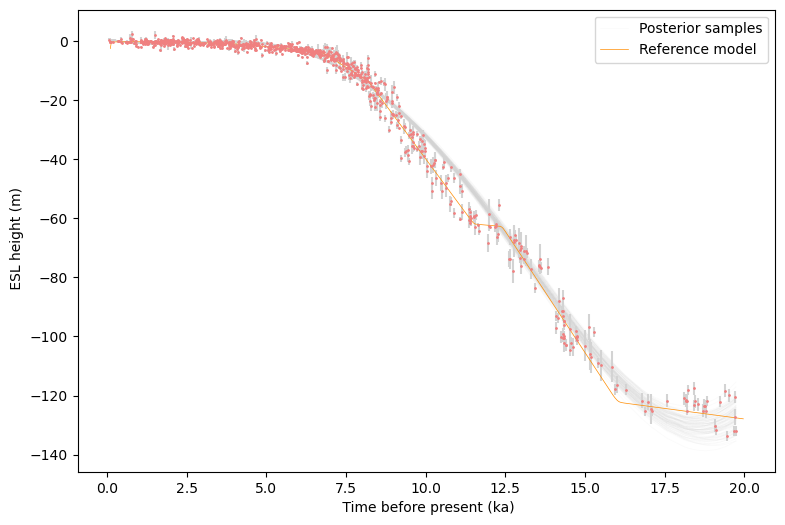

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.3.dev1
numpy 1.21.6
scipy 1.10.1
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
